**Name:** Siddharth Betala

**Roll Number:** BE19B032

PS: **In this assignment, whenever I have used the term SGD to represent mini-batch/batch gradient descent. Please excuse this misnomer.**

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
import torch
import numpy as np
import random

def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed(42)

# Activation Functions

In [3]:
class Activation:

    def __init__(self, *args, **kwargs):
        self.grads = {}
        self.backprop_cache = {}

    def __call__(self, *args, **kwargs):
        op = self.forward(*args, **kwargs)
        self.grads = self.calc_grads(*args, **kwargs)
        return op

    def forward(self, *args, **kwargs):
        pass

    def calc_grads(self, *args, **kwargs):
        pass

    def backward(self, *args, **kwargs):
        pass

In [4]:
class Sigmoid(Activation):

    def __init__(self):
        super().__init__()

    def forward(self, x):
        self.backprop_cache = 1/(1+np.exp(-x))
        return self.backprop_cache

    def calc_grads(self, x):
        id = "x"
        y = self.backprop_cache
        delta = y*(1-y)
        return {id:delta}

    def backward(self, yhat):
        return self.grads['x']*yhat

class Tanh(Activation):

    def __init__(self):
        super().__init__()

    def forward(self, x):
        self.backprop_cache = (np.exp(x) - np.exp(-x))/(np.exp(x)+np.exp(-x))
        return self.backprop_cache

    def calc_grads(self, x):
        id = "x"
        y = self.backprop_cache
        delta = 1-y**2
        return {id:delta}

    def backward(self, yhat):
        return self.grads['x']*yhat

class ReLU(Activation):

    def __init__(self):
        super().__init__()

    def forward(self, x):
        self.backprop_cache = np.maximum(x, 0.0)
        return self.backprop_cache

    def calc_grads(self, x):
        id = "x"
        y = self.backprop_cache
        delta = (y>0).astype("float")
        return {id:delta}

    def backward(self, yhat):
        return self.grads['x']*yhat

class LeakyReLU(Activation):

    def __init__(self, alpha = 0.1):
        super().__init__()
        self.alpha = alpha

    def forward(self, x):
        self.backprop_cache = np.maximum(x, self.alpha*x)
        return self.backprop_cache

    def calc_grads(self, x):
        id = "x"
        y = self.backprop_cache
        delta = np.where(y > 0, 1, self.alpha)
        return {id:delta}

    def backward(self, yhat):
        return self.grads['x']*yhat

class Linear(Activation):

    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

    def calc_grads(self, x):
        id = "x"
        delta = np.ones_like(x)
        return {id:delta}

    def backward(self, yhat):
        return self.grads['x'] * yhat

# Loss Functions

## Helper Function: Softmax for Output Layer

In [5]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis= -1, keepdims=True))
    return exp_x/ np.sum(exp_x, axis = -1, keepdims=True)

In [6]:
class Loss:

    def __init__(self, *args, **kwargs):
        self.grads = {}
        self.backprop_cache = {}

    def __call__(self, y_pred, y_true, *args, **kwargs):
        op = self.forward(y_pred, y_true, *args, **kwargs)
        self.grads = self.calc_grads(y_pred, y_true, *args, **kwargs)
        return op

    def forward(self, y_pred, y_true, *args, **kwargs):
        pass

    def calc_grads(self, y_pred, y_true, *args, **kwargs):
        pass

    def backward(self, *args, **kwargs):
        return self.grads['x']

In [7]:
class MSE(Loss):

    def __init__(self):
        super().__init__()

    def forward(self, y_pred, y_true):
        num_classes = y_pred.shape[-1]
        probabs = softmax(y_pred)
        y_true_encoding = np.eye(num_classes, dtype = int)[np.array(y_true).astype(int)]
        self.backprop_cache['y_true'] = y_true_encoding
        loss = np.mean(np.sum((probabs-y_true_encoding)**2, axis =1))
        self.backprop_cache['probabs'] = probabs
        return loss

    def calc_grads(self, y_pred, y_true):
        batch_size = y_pred.shape[0]
        sub_term = self.backprop_cache["probabs"] - self.backprop_cache["y_true"]
        grad = (sub_term - (sub_term*self.backprop_cache["probabs"]).sum(axis = 1, keepdims = True))*self.backprop_cache["probabs"]
        grad = grad/batch_size
        return {'x': grad}


class LogLoss(Loss):

    def __init__(self):
        super().__init__()

    def forward(self, y_pred, y_true):
        num_classes = y_pred.shape[-1]
        probabs = softmax(y_pred)
        y_true_encoding = np.eye(num_classes, dtype = int)[np.array(y_true).astype(int)]
        self.backprop_cache['y_true'] = y_true_encoding
        loss = np.mean(- np.log(probabs[np.arange(y_pred.shape[0]), y_true] + 1e-16)) #added the 1e-16 term to avoid division by 0 error in log
        self.backprop_cache['probabs'] = probabs
        return loss

    def calc_grads(self, y_pred, y_true):
        batch_size = y_pred.shape[0]
        grad = self.backprop_cache['probabs'] - self.backprop_cache['y_true']
        grad = grad/batch_size
        return {'x': grad}

# Optimizers

Formulae for different optimizers taken from class slides and online resources

In [8]:
class Optimizer:

    def __init__(self, *args, **kwargs):
        self.history = {}
        pass

    def update_weights(self, layer, *args, **kwargs):

        update = self.calc_update(layer)
        for k, v in layer.weights.items():
            layer.weights[k] = layer.weights[k] + update[k]

    def calc_update(self, layer, *args, **kwargs):
        pass

    def _get_unique_key(self, layer, key):
        """Helper function to get a unique key for the layer and attribute."""
        return (id(layer), key)

In [9]:
class SGD(Optimizer):
    '''
    Although this has been named as SGD, it acts as mini-batch gradient descent.
    I have used the terms interchangeably in this assignment.
    '''

    def __init__(self, learning_rate = 0.01):

        super().__init__()
        self.learning_rate = learning_rate

    def calc_update(self, layer):

        update = {}

        for k, v in layer.weights.items():
            update[k] = -self.learning_rate*layer.del_theta[k]
        return update

class Momentum(Optimizer):

    def __init__(self, learning_rate=0.01, beta=0.9):

        super().__init__()
        self.learning_rate = learning_rate
        self.beta = beta

    def calc_update(self, layer):

        update = {}

        for k, v in layer.weights.items():
            unique_key = self._get_unique_key(layer, k)

            if unique_key in self.history:
                self.history[unique_key]['u'] = self.beta * self.history[unique_key]['u'] + self.learning_rate * layer.del_theta[k]
            else:
                self.history[unique_key] = {}
                self.history[unique_key]['u'] = self.learning_rate * layer.del_theta[k]

            update[k] = -self.history[unique_key]['u']

        return update

class RMSProp(Optimizer):

    def __init__(self, learning_rate = 0.01, beta = 0.9, epsilon = 1e-7):

        super().__init__()
        self.learning_rate = learning_rate
        self.beta = beta
        self.epsilon = epsilon

    def calc_update(self, layer):

        update = {}

        for k, v in layer.weights.items():
            unique_key = self._get_unique_key(layer, k)

            if unique_key in self.history:
                self.history[unique_key]['u'] = self.beta*self.history[unique_key]['u'] + (1-self.beta)*(layer.del_theta[k]**2)
            else:
                self.history[unique_key] = {}
                self.history[unique_key]['u'] = (1-self.beta)*(layer.del_theta[k]**2)

            sqrt_term = np.sqrt(self.history[unique_key]['u'] + self.epsilon)
            update[k] = -(self.learning_rate*layer.del_theta[k]/sqrt_term)
        return update

class Adam(Optimizer):

    def __init__(self, learning_rate = 0.01, epsilon = 1e-7, beta1 = 0.9, beta2 = 0.999):

        super().__init__()
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.beta1 = beta1
        self.beta2 = beta2
        self.steps = 1

    def calc_update(self, layer):

        update = {}

        for k, v in layer.weights.items():
            unique_key = self._get_unique_key(layer, k)

            if unique_key in self.history:
                self.history[unique_key]['m'] = self.beta1*self.history[unique_key]['m'] + (1-self.beta1)*layer.del_theta[k]
                self.history[unique_key]['u'] = self.beta2*self.history[unique_key]['u'] + (1-self.beta2)*(layer.del_theta[k]**2)

            else:
                self.history[unique_key] = {}
                self.history[unique_key]['m'] = (1-self.beta1)*layer.del_theta[k]
                self.history[unique_key]['u'] = (1-self.beta2)*(layer.del_theta[k]**2)

            corrected_avg = self.history[unique_key]['m']/(1-(self.beta1)**self.steps)
            corrected_sq_avg = self.history[unique_key]['u']/(1-(self.beta2)**self.steps)

            sqrt_term = np.sqrt(corrected_sq_avg) + self.epsilon
            update[k] = -self.learning_rate*corrected_avg/sqrt_term

        self.steps+=1
        return update

# Layer Class

## Helper Class: Weight Initialization

In [10]:
def xavier_weight_init(in_dim, out_dim):
    limit = np.sqrt(6 / (in_dim + out_dim))
    weights = np.random.uniform(low=-limit, high=limit, size=(in_dim, out_dim))
    biases = np.zeros((1, out_dim))
    return weights, biases

In [11]:
class Layer:

    def __init__(self, *args, **kwargs):
        self.grads = {}
        self.weights = {}
        self.backprop_cache = {}
        self.optimizer = None

    def __call__(self, *args, **kwargs):

        op = self.forward(*args, **kwargs)
        self.grads = self.calc_grads(*args, **kwargs)
        return op

    def init_weights(self, *args, **kwargs):
        pass

    def forward(self, *args, **kwargs):
        pass

    def calc_grads(self, *args, **kwargs):
        pass

    def backward(self, *args, **kwargs):
        pass

    def update_weights(self, *args, **kwargs):
        self.optimizer.update_weights(self)

In [12]:
class FNNLayer(Layer):

    def __init__(self, in_dim, out_dim, weight_decay = None):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.weight_decay = weight_decay
        self.init_weights()

    def init_weights(self):
        self.weights['w'], self.weights['b'] = xavier_weight_init(self.in_dim, self.out_dim)

    def forward(self, x):
        self.backprop_cache['x'] = x
        op = np.einsum('ij,jk->ik', x, self.weights["w"]) + self.weights["b"]
        return op

    def calc_grads(self, x):
        dels = {}
        dels['w'] = np.einsum('ij -> ji', self.backprop_cache['x'])
        dels['x'] = np.einsum('ij -> ji', self.weights['w'])

        return dels

    def backward(self, yhat):
        xhat = np.einsum('ij,jk->ik', yhat, self.grads["x"])
        what = np.einsum('ij,jk->ik', self.grads["w"], yhat)
        bhat = np.sum(yhat, axis=0, keepdims=True)
        if self.weight_decay:
            what = what + 2 * self.weight_decay * self.weights["w"]
            bhat = bhat + 2 * self.weight_decay * self.weights["b"]
        self.del_theta = {'w': what, 'b': bhat}
        return xhat

    def update_weights(self):
        self.optimizer.update_weights(self)

# Putting it all together as a NN

## Helper Function for Copy

In [13]:
from copy import deepcopy as std_deepcopy

def custom_deepcopy(arr):
    if isinstance(arr, np.ndarray):
        return np.array([custom_deepcopy(elem) for elem in arr])
    else:
        return std_deepcopy(arr)

In [14]:
class NN():
    def __init__(self, layers):
        self.layers = layers
        self.history = []
        self.iteration_losses = []
        self.iteration_test_losses = []

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

    def compile(self, loss, optimizer):
        self.loss = loss
        for layer in self.layers:
            if isinstance(layer, (Layer, FNNLayer)) and layer.optimizer is None:
                if isinstance(optimizer, np.ndarray):
                    layer.optimizer = custom_deepcopy(optimizer)
                else:
                    layer.optimizer = std_deepcopy(optimizer)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def backward(self):
        grad = self.loss.backward()
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad

    def update_weights(self):
        for layer in reversed(self.layers):
            if isinstance(layer, (Layer, FNNLayer)):
                layer.update_weights()

    def fit(self, X_train, Y_train, X_test, Y_test, batch_size=64, epochs=15, lr=0.01, log_interval=200):
        train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
        test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(Y_test))

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        iteration_counter = 0
        for epoch in range(1, epochs+1):
            tr_loss_epoch, tr_acc = 0, 0

            # Training phase
            for batch_idx, (X_t, Y_t) in enumerate(train_loader):
                X_t, Y_t = X_t.numpy(), Y_t.numpy()
                preds = self(X_t)
                tr_loss_batch = self.loss(preds, Y_t)
                tr_loss_epoch += tr_loss_batch
                tr_acc += np.mean(np.argmax(preds, axis=1) == Y_t)
                self.backward()
                self.update_weights()

                iteration_counter += 1
                if iteration_counter % log_interval == 0:
                    te_loss = 0
                    test_batches = 0  # Counter for the number of test batches
                    for X_te, Y_te in test_loader:
                        X_te, Y_te = X_te.numpy(), Y_te.numpy()
                        te_preds = self(X_te)
                        te_loss += self.loss(te_preds, Y_te)
                        test_batches += 1

                    average_te_loss = te_loss / test_batches  # Average the test loss over batches
                    self.iteration_losses.append(tr_loss_batch)  # Store the training loss
                    self.iteration_test_losses.append(average_te_loss)  # Store the test loss

                    print(f"Iteration: {iteration_counter} Train Loss: {tr_loss_batch} Test Loss: {average_te_loss}")

            mean_tr_loss_epoch = tr_loss_epoch / (batch_idx + 1)  # Average loss per batch
            mean_tr_acc = tr_acc / (batch_idx + 1)  # Average accuracy per batch
            self.history.append({
                "Epoch": epoch,
                "Train Loss": mean_tr_loss_epoch,
                "Train Accuracy": mean_tr_acc
            })

            print(f"Epoch: {epoch} Mean Train Loss: {mean_tr_loss_epoch} Train Accuracy: {mean_tr_acc * 100:.2f}%")

        print('Model trained!')

    def evaluate(self, X_train, Y_train, X_test, Y_test):
    # Train accuracy
        train_preds = self(X_train)
        train_loss = self.loss(train_preds, Y_train)
        train_accuracy = np.mean(np.argmax(train_preds, axis=1) == Y_train)

        # Test accuracy
        test_preds = self(X_test)
        test_loss = self.loss(test_preds, Y_test)
        test_accuracy = np.mean(np.argmax(test_preds, axis=1) == Y_test)

        true_labels = Y_test
        predicted_labels = np.argmax(test_preds, axis=1)
        cm = confusion_matrix(true_labels, predicted_labels)
        cr = classification_report(true_labels, predicted_labels)

        print(f"Train loss: {train_loss} Train accuracy: {train_accuracy * 100:.2f}%")
        print(f"Test loss: {test_loss} Test accuracy: {test_accuracy * 100:.2f}%")
        print("\nConfusion Matrix:\n", cm)
        print("\nClassification Report:\n", cr)


    def plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.iteration_losses, label='Training Loss', color='blue')
        plt.plot(self.iteration_test_losses, label='Test Loss', color='red', linestyle='--')
        plt.xlabel('Iterations (x200)')
        plt.ylabel('Loss')
        plt.title('Loss Convergence')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_confusion_matrix(self, X_test, Y_test):
        preds = self(X_test)
        predicted_labels = np.argmax(preds, axis=1)
        cm = confusion_matrix(Y_test, predicted_labels)

        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        plt.figure(figsize=(10, 8))

        sns.heatmap(cm_normalized, annot=cm, fmt='g', cmap='Blues',
                    xticklabels=[str(i) for i in range(10)],
                    yticklabels=[str(i) for i in range(10)])

        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()

## Loading the dataset

In [15]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from sklearn.preprocessing import StandardScaler

transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.numpy().reshape(28*28))])
mnist_train = MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = MNIST(root='./data', train=False, download=True, transform=transform)

# Extract transformed data
X_train = [data[0] for data in mnist_train]
Y_train = [data[1] for data in mnist_train]
X_test = [data[0] for data in mnist_test]
Y_test = [data[1] for data in mnist_test]

X_train = np.vstack(X_train)
Y_train = np.array(Y_train)
X_test = np.vstack(X_test)
Y_test = np.array(Y_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

100%|██████████| 9912422/9912422 [00:00<00:00, 115686038.46it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 29119157.17it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 28049299.55it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15475652.94it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# The MLP

## Model Setup

In [ ]:
input_dim = 28 * 28
output_dim = 10

layers = [
    FNNLayer(input_dim, 500),
    Sigmoid(),
    FNNLayer(500, 250),
    Sigmoid(),
    FNNLayer(250, 100),
    Sigmoid(),
    FNNLayer(100, output_dim)
]

model = NN(layers)

## Model Compilation

In [ ]:
optimizer = SGD()
loss = LogLoss()
model.compile(loss=loss, optimizer=optimizer)

## Training

In [ ]:
model.fit(X_train, Y_train, X_test, Y_test)

Iteration: 200 Train Loss: 2.28404012346916 Test Loss: 2.2881730692377955
Iteration: 400 Train Loss: 2.2871254061109076 Test Loss: 2.2752235510892405
Iteration: 600 Train Loss: 2.273921054489516 Test Loss: 2.2606282347853868
Iteration: 800 Train Loss: 2.2269116640387248 Test Loss: 2.246660426078933
Epoch: 1 Mean Train Loss: 2.2717962347989644 Train Accuracy: 20.39%
Iteration: 1000 Train Loss: 2.233237676925383 Test Loss: 2.226415003427589
Iteration: 1200 Train Loss: 2.2372321501307884 Test Loss: 2.2033946405378333
Iteration: 1400 Train Loss: 2.1892218536408423 Test Loss: 2.1760851011238542
Iteration: 1600 Train Loss: 2.157169121515797 Test Loss: 2.142309073982135
Iteration: 1800 Train Loss: 2.1170892522196443 Test Loss: 2.0992441334576637
Epoch: 2 Mean Train Loss: 2.1708157127067658 Train Accuracy: 41.31%
Iteration: 2000 Train Loss: 2.060762568881711 Test Loss: 2.0423580138521213
Iteration: 2200 Train Loss: 1.9380380403103494 Test Loss: 1.9722423582668709
Iteration: 2400 Train Loss: 1.

## Evaluation

In [ ]:
model.evaluate(X_train, Y_train, X_test, Y_test)

Train loss: 0.3519457452554122 Train accuracy: 90.09%
Test loss: 0.35226903080223715 Test accuracy: 90.09%

Confusion Matrix:
 [[ 953    0    5    1    1    8    8    1    3    0]
 [   0 1108    3    4    1    0    3    1   14    1]
 [  13    6  926   17   10    1   16    7   34    2]
 [   1    2   31  892    1   36    2   20   19    6]
 [   1    5    5    0  915    1   16    7    5   27]
 [  16    2    8   59   16  720   21   11   32    7]
 [  15    3   14    0   10   18  894    0    4    0]
 [   4   20   23    3    5    0    0  915    3   55]
 [   9   13   10   26   19   35   12    9  825   16]
 [  15    7    1    9   63    8    0   36    9  861]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95       980
           1       0.95      0.98      0.96      1135
           2       0.90      0.90      0.90      1032
           3       0.88      0.88      0.88      1010
           4       0.88      0.93      0.90   

## Loss Plot Visualization

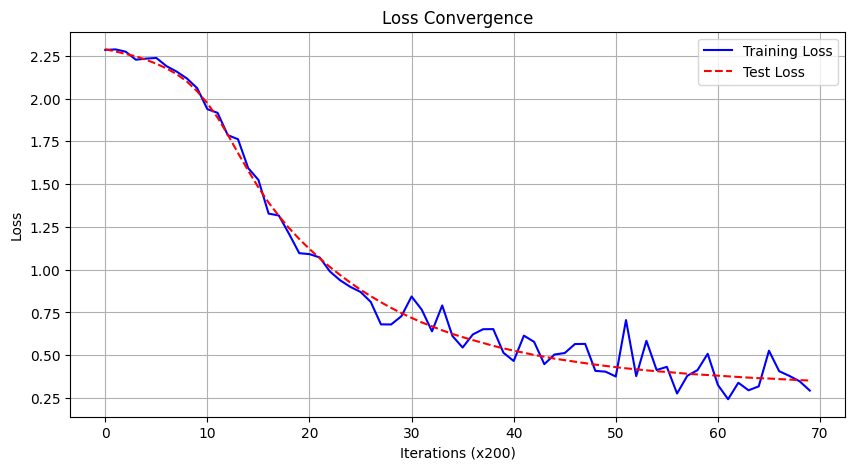

In [ ]:
model.plot_losses()

## Confusion Matrix

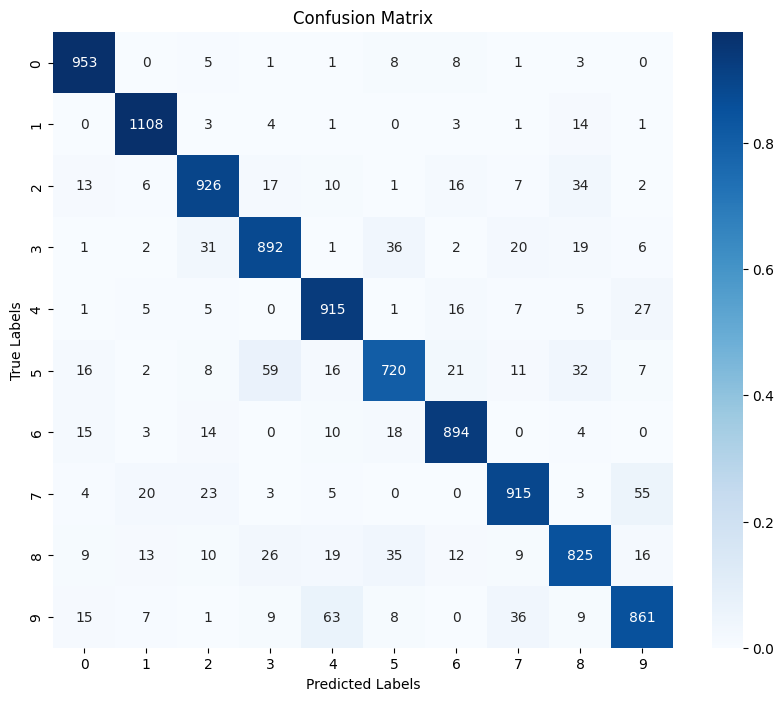

In [ ]:
model.plot_confusion_matrix(X_test, Y_test)

## Performance with Tanh Activation Function

In [ ]:
input_dim = 28 * 28
output_dim = 10

layers = [
    FNNLayer(input_dim, 500),
    Tanh(),
    FNNLayer(500, 250),
    Tanh(),
    FNNLayer(250, 100),
    Tanh(),
    FNNLayer(100, output_dim)
]

tanh_model = NN(layers)
optimizer = SGD()
loss = LogLoss()
tanh_model.compile(loss=loss, optimizer=optimizer)
tanh_model.fit(X_train, Y_train, X_test, Y_test)

Iteration: 200 Train Loss: 0.6369368598487277 Test Loss: 0.5204944292061252
Iteration: 400 Train Loss: 0.4731155648871941 Test Loss: 0.3966134160792771
Iteration: 600 Train Loss: 0.3593909323036678 Test Loss: 0.34781203184417436
Iteration: 800 Train Loss: 0.38377500422886823 Test Loss: 0.31953915528730015
Epoch: 1 Mean Train Loss: 0.4968723584018799 Train Accuracy: 86.40%
Iteration: 1000 Train Loss: 0.2581839410137612 Test Loss: 0.3000319568198122
Iteration: 1200 Train Loss: 0.36569183827688745 Test Loss: 0.28483428819911477
Iteration: 1400 Train Loss: 0.3810463944529671 Test Loss: 0.2742792119515289
Iteration: 1600 Train Loss: 0.26286587705052156 Test Loss: 0.2652769409733449
Iteration: 1800 Train Loss: 0.1418390759312137 Test Loss: 0.25637487613564
Epoch: 2 Mean Train Loss: 0.27796630698948344 Train Accuracy: 92.14%
Iteration: 2000 Train Loss: 0.4836013812226341 Test Loss: 0.2508604669724864
Iteration: 2200 Train Loss: 0.34252821276883105 Test Loss: 0.24503222890167545
Iteration: 240

In [ ]:
tanh_model.evaluate(X_train, Y_train, X_test, Y_test)

Train loss: 0.06980811358605145 Train accuracy: 98.35%
Test loss: 0.13803422907071627 Test accuracy: 95.88%

Confusion Matrix:
 [[ 965    0    2    2    1    5    3    1    1    0]
 [   0 1119    7    0    0    1    4    1    3    0]
 [   7    1  972    9   10    3    6   10   14    0]
 [   0    0    5  974    3   10    1    8    5    4]
 [   2    0    4    2  942    0    8    5    4   15]
 [   3    0    3    9    4  848    8    2   13    2]
 [   9    3    3    1    5   11  924    0    2    0]
 [   1    7   12    6    6    0    0  977    1   18]
 [   5    2    6   14    7    7    4    6  918    5]
 [   8    6    3    9   16    5    0   10    3  949]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.96      0.94      0.95      1032
           3       0.95      0.96      0.96      1010
           4       0.95      0.96      0.95  

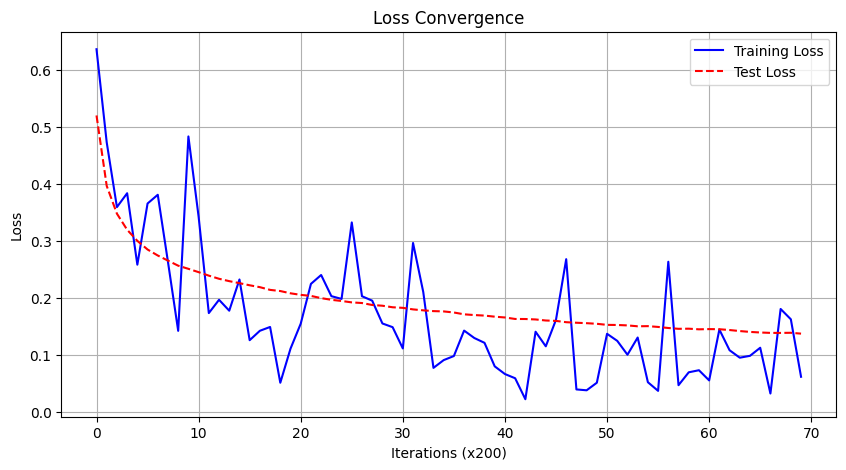

In [ ]:
tanh_model.plot_losses()

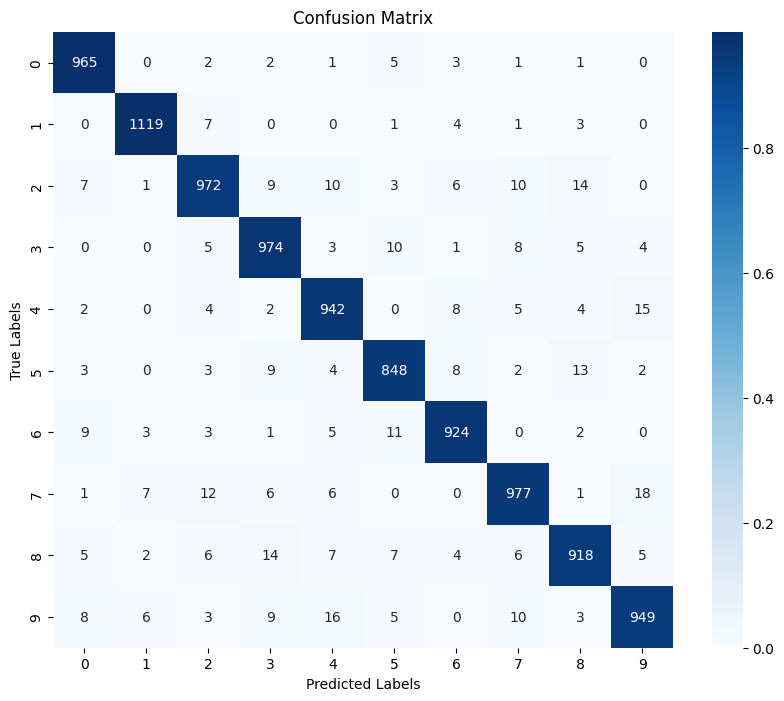

In [ ]:
tanh_model.plot_confusion_matrix(X_test, Y_test)

## Performance with ReLU

In [ ]:
input_dim = 28 * 28
output_dim = 10

layers = [
    FNNLayer(input_dim, 500),
    ReLU(),
    FNNLayer(500, 250),
    ReLU(),
    FNNLayer(250, 100),
    ReLU(),
    FNNLayer(100, output_dim)
]

relu_model = NN(layers)
optimizer = SGD()
loss = LogLoss()
relu_model.compile(loss=loss, optimizer=optimizer)
relu_model.fit(X_train, Y_train, X_test, Y_test)

Iteration: 200 Train Loss: 0.49656280943967623 Test Loss: 0.5764013924102541
Iteration: 400 Train Loss: 0.33035301264252803 Test Loss: 0.3785817038090857
Iteration: 600 Train Loss: 0.3051923915988052 Test Loss: 0.31481117270753967
Iteration: 800 Train Loss: 0.36569342720154085 Test Loss: 0.28482584297799485
Epoch: 1 Mean Train Loss: 0.534597634309576 Train Accuracy: 85.52%
Iteration: 1000 Train Loss: 0.19961381905857606 Test Loss: 0.25501981022511705
Iteration: 1200 Train Loss: 0.3820573081166786 Test Loss: 0.23698910098709547
Iteration: 1400 Train Loss: 0.09108320797688393 Test Loss: 0.22359471283327687
Iteration: 1600 Train Loss: 0.16115695255330909 Test Loss: 0.21497579903385425
Iteration: 1800 Train Loss: 0.25517579316822603 Test Loss: 0.20243368440502613
Epoch: 2 Mean Train Loss: 0.20831057304886846 Train Accuracy: 93.92%
Iteration: 2000 Train Loss: 0.07802013358843116 Test Loss: 0.1912903684860585
Iteration: 2200 Train Loss: 0.14263492077655393 Test Loss: 0.19087514564516692
Iter

In [ ]:
relu_model.evaluate(X_train, Y_train, X_test, Y_test)

Train loss: 0.022803324674423416 Train accuracy: 99.58%
Test loss: 0.12120565281551551 Test accuracy: 96.91%

Confusion Matrix:
 [[ 964    1    3    1    1    4    5    1    0    0]
 [   0 1125    3    0    0    1    3    1    2    0]
 [   8    1  993    2    3    2    5    6   11    1]
 [   0    0    4  981    0    7    1    5    7    5]
 [   2    1    6    1  953    0    4    4    3    8]
 [   2    0    2    7    2  866    5    2    5    1]
 [   7    2    1    1    6    9  932    0    0    0]
 [   0    6   12    3    1    1    0  992    4    9]
 [   3    0    5    8    5    9    4    6  930    4]
 [   4    3    0    9   14    6    0   12    6  955]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.96      0.96      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.97      0.97 

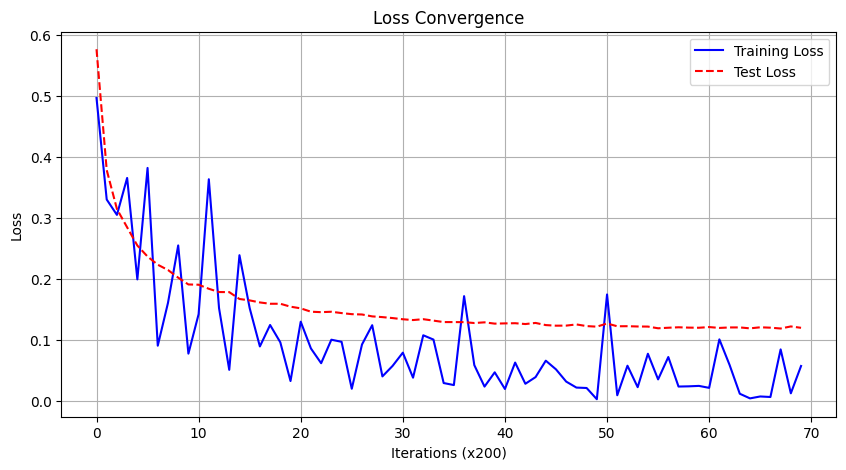

In [ ]:
relu_model.plot_losses()

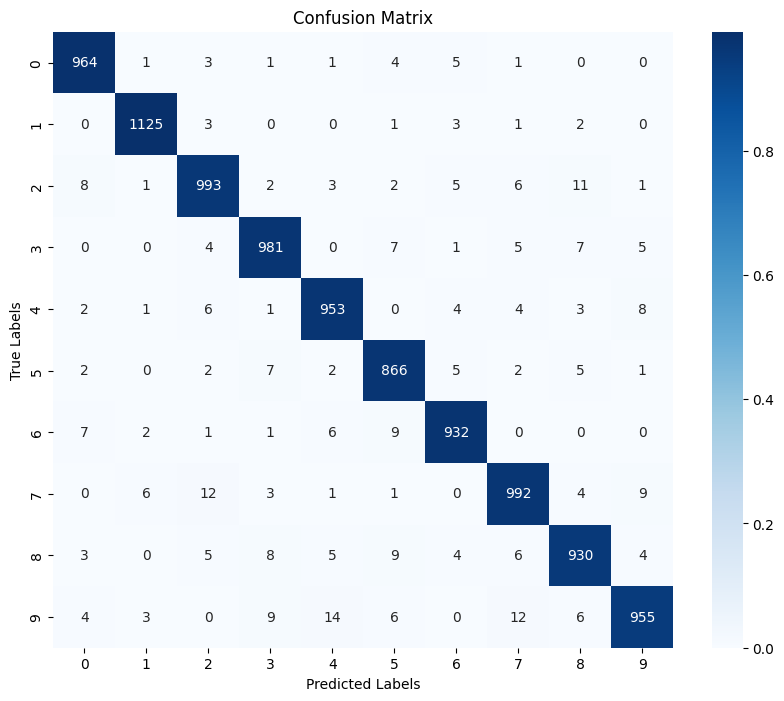

In [ ]:
relu_model.plot_confusion_matrix(X_test, Y_test)

## Performance with Leaky ReLU

In [ ]:
input_dim = 28 * 28
output_dim = 10

layers = [
    FNNLayer(input_dim, 500),
    LeakyReLU(),
    FNNLayer(500, 250),
    LeakyReLU(),
    FNNLayer(250, 100),
    LeakyReLU(),
    FNNLayer(100, output_dim)
]

lrelu_model = NN(layers)
optimizer = SGD()
loss = LogLoss()
lrelu_model.compile(loss=loss, optimizer=optimizer)
lrelu_model.fit(X_train, Y_train, X_test, Y_test)

Iteration: 200 Train Loss: 0.5837200255888777 Test Loss: 0.5714556908020015
Iteration: 400 Train Loss: 0.532756667308845 Test Loss: 0.3791947861155695
Iteration: 600 Train Loss: 0.48849123043183723 Test Loss: 0.3213814851909864
Iteration: 800 Train Loss: 0.15478070904859037 Test Loss: 0.27657555910327714
Epoch: 1 Mean Train Loss: 0.5275257893492852 Train Accuracy: 85.74%
Iteration: 1000 Train Loss: 0.28693668118054955 Test Loss: 0.26280551556033505
Iteration: 1200 Train Loss: 0.17584558065311043 Test Loss: 0.2409190163417514
Iteration: 1400 Train Loss: 0.2798806351774464 Test Loss: 0.22510041261240019
Iteration: 1600 Train Loss: 0.5242409291215124 Test Loss: 0.21618383171032865
Iteration: 1800 Train Loss: 0.10196507305350727 Test Loss: 0.20567736847263202
Epoch: 2 Mean Train Loss: 0.21577161565623157 Train Accuracy: 93.71%
Iteration: 2000 Train Loss: 0.11032247228589825 Test Loss: 0.19925980787120282
Iteration: 2200 Train Loss: 0.09947097742695399 Test Loss: 0.19154027127945855
Iterati

In [ ]:
lrelu_model.evaluate(X_train, Y_train, X_test, Y_test)

Train loss: 0.026928010522560643 Train accuracy: 99.46%
Test loss: 0.11234078461906374 Test accuracy: 97.04%

Confusion Matrix:
 [[ 964    0    3    2    1    2    3    1    3    1]
 [   0 1122    5    0    0    1    4    0    3    0]
 [   4    4 1000    4    2    0    5    5    6    2]
 [   0    0    4  986    0    3    2    5    6    4]
 [   2    0    6    1  954    0    3    3    2   11]
 [   2    0    0   12    1  863    3    3    7    1]
 [   8    2    1    1    6    9  927    0    4    0]
 [   1    9    8    2    2    1    0  992    0   13]
 [   2    0    5   14    4    8    3    5  930    3]
 [   3    6    0   10    8    4    0    7    5  966]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.96      0.98      0.97      1010
           4       0.98      0.97      0.97 

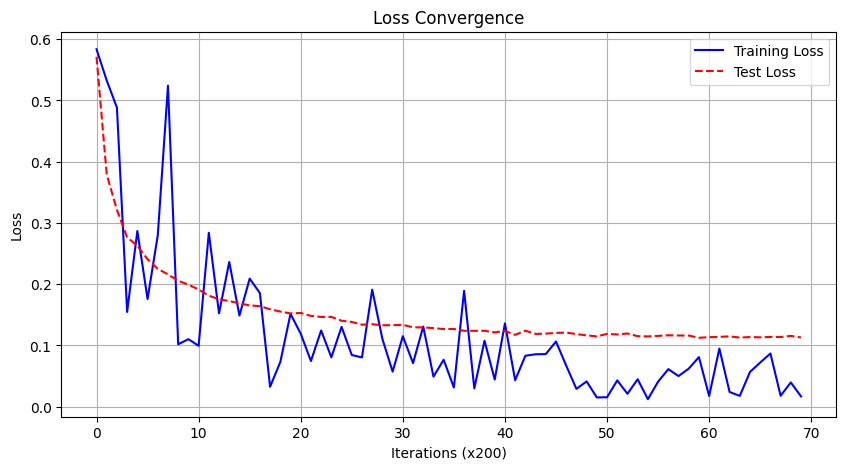

In [ ]:
lrelu_model.plot_losses()

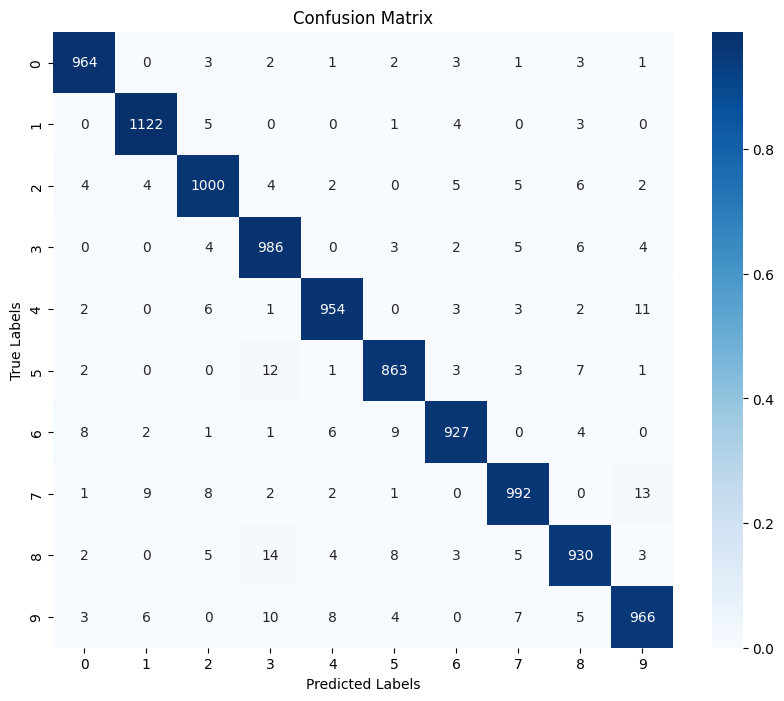

In [ ]:
lrelu_model.plot_confusion_matrix(X_test, Y_test)

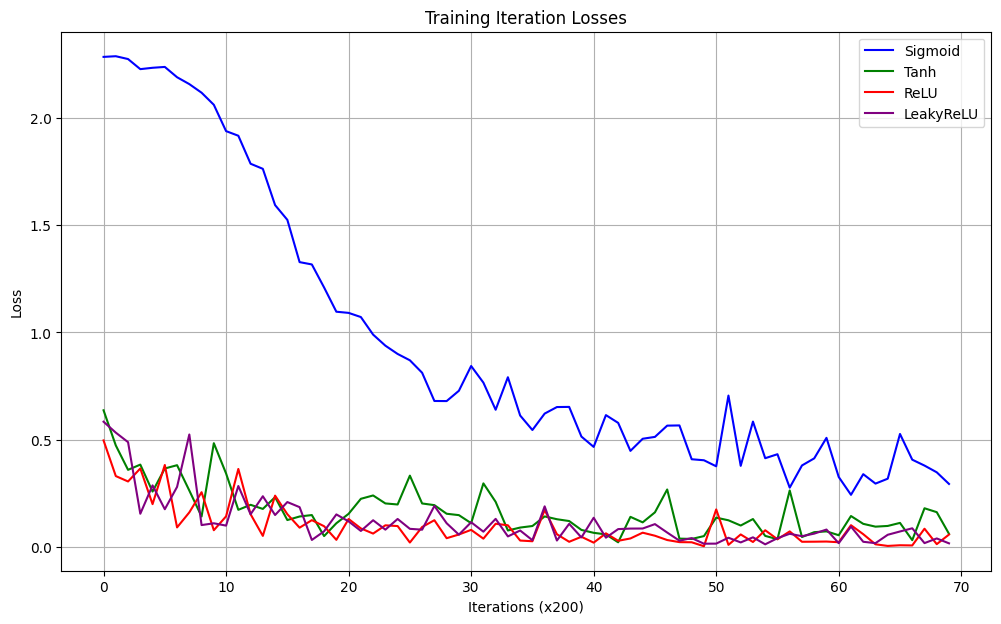

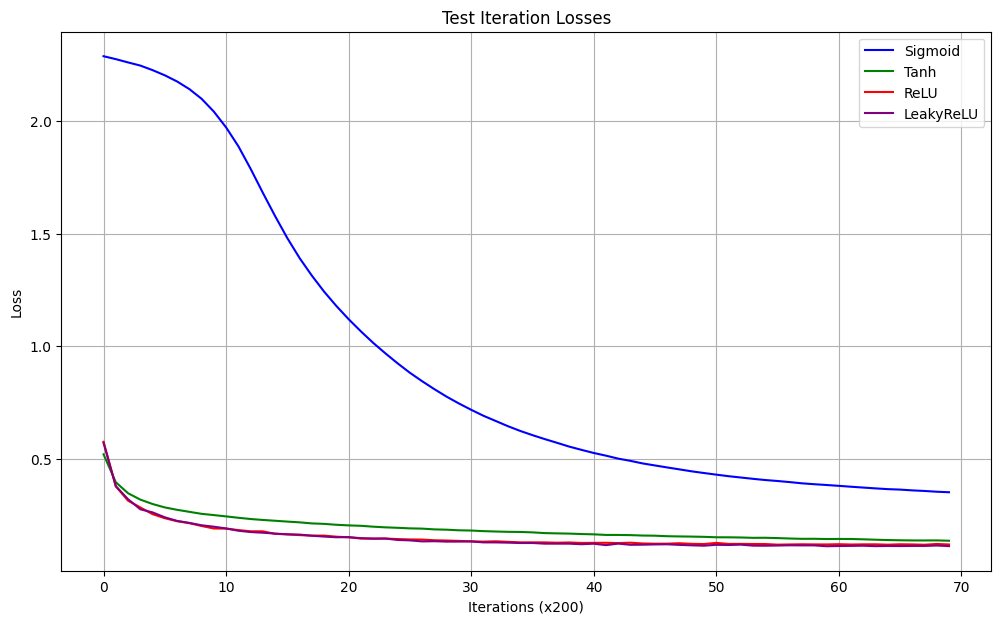

In [ ]:
import matplotlib.pyplot as plt

def plot_models_losses(models, labels, title, attribute):
    plt.figure(figsize=(12, 7))

    colors = ['blue', 'green', 'red', 'purple']

    for i, model in enumerate(models):
        losses = getattr(model, attribute)
        plt.plot(losses, label=labels[i], color=colors[i])

    plt.xlabel('Iterations (x200)')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

model1 = model
model2 = tanh_model
model3 = relu_model
model4 = lrelu_model

models = [model1, model2, model3, model4]
labels = ['Sigmoid', 'Tanh', 'ReLU', 'LeakyReLU']

# Plots training iteration losses
plot_models_losses(models, labels, 'Training Iteration Losses', 'iteration_losses')

# Plots test iteration losses
plot_models_losses(models, labels, 'Test Iteration Losses', 'iteration_test_losses')

## Observations

Activation  | Test Accuracy | Train Accuracy | Train Loss| Test Loss
-------------------|------------------|---------------|------------|------------
      Sigmoid|  90.09% |  90.09%| 0.3519 | 0.3523|
       Tanh| 95.88% | 98.35% | 0.0698 | 0.1380 |
       ReLU|  96.91% | 99.58% | 0.0228 | 0.1212 |
       Leaky ReLU  | 97.04% | 99.46% | 0.0269 | 0.1123

The values in this table might change based on the run. The observations might be affected slightly as a result.

ReLU and Leaky ReLU outperform all the other activation functions.


*   ReLU is expected to perform better than Sigmoid and Tanh functions because it doesn't squash output values to a narrow range, so gradients aren't as susceptible to vanishing.  
*   ReLU doesn't saturate for positive values. This means it doesn't suffer as much from the vanishing gradient problem. Gradients flow easily during backpropagation, which can result in faster convergence.
*   Tanh squashes its outputs to be in the range [-1, 1], which can be more desirable than [0, 1] in some scenarios as it centers the output around 0.
*    For inputs close to 0, tanh has a steeper gradient compared to the sigmoid function, which can result in faster learning.
*   I wanted to experiment with Leaky ReLU as sometimes it is possible that the dying ReLU problem comes up, in which neurons get stuck during training and stop updating their weights. his happens when a large gradient flows through a ReLU neuron, updating the weights in such a way that the neuron will always output 0.
*   We don't alywas see Leaky ReLU outperform ReLU though. This may be because the dying ReLU issue isn't dominant here for such a  simple dataset. My choice of the hyperparameter alpha in Leaky ReLU might just be luckily ideal for this setting as well. Plus, I am not sure if I am using the term correctly, but leaky ReLU might be offering a regularization effect:  if some neurons become inactive, it could force other parts of the network to adapt and generalize better.
* Weight initialization can significantly influence the early stages of training by determining the initial magnitude of neuron activations and gradients. If the activations are too large or too small, it can either slow down learning or cause it to diverge altogether.  
*   Even though we are comparing the performance of these activation functions on the same architecture and hyperparameters (learning rate, batch size), the performance is definitely subject to the weight initialization which is different for all the 4 models as weights are initialized separately for each model. Our hope is that with enough epochs, each model gets a chance to overcome the shortcomings of their initializations, but still the performance does depend on it.
*   For example, if weights are initialized too small, especially for sigmoid or tanh, activations can get squashed into the saturated regions, leading to the vanishing gradient problem. As a result, learning will be very slow.
*   If we set 95% test accuracy as a benchmark for acceotable performance, both ReLU and leaky ReLU achieve that by the 3rd epoch of training. TanH is also commendable as it gets there by its 6th epoch. However, even 15 epochs aren't enough for the sigmoid activation function. Either it leads to slow convergence or its weight in this run were initialized very poorly.
*   Among the 3 options given in the assignment, ReLU performs the best, so we'll consider that to be our activation function in the baseline going ahead.















# Performance of the best baseline model with other optimizers

## Momentum

In [ ]:
input_dim = 28 * 28
output_dim = 10

layers = [
    FNNLayer(input_dim, 500),
    ReLU(),
    FNNLayer(500, 250),
    ReLU(),
    FNNLayer(250, 100),
    ReLU(),
    FNNLayer(100, output_dim)
]

best_model_momentum = NN(layers)
optimizer = Momentum()
loss = LogLoss()
best_model_momentum.compile(loss=loss, optimizer=optimizer)
best_model_momentum.fit(X_train, Y_train, X_test, Y_test)

Iteration: 200 Train Loss: 0.2831846500824217 Test Loss: 0.2739371801716733
Iteration: 400 Train Loss: 0.3509966008712886 Test Loss: 0.23237908831807264
Iteration: 600 Train Loss: 0.1848757538311216 Test Loss: 0.1921458697739969
Iteration: 800 Train Loss: 0.21470706763327163 Test Loss: 0.16444030258385292
Epoch: 1 Mean Train Loss: 0.27697266153109423 Train Accuracy: 92.21%
Iteration: 1000 Train Loss: 0.043229211169753555 Test Loss: 0.1368287007421211
Iteration: 1200 Train Loss: 0.09366322273931255 Test Loss: 0.14043229370694368
Iteration: 1400 Train Loss: 0.04675467104091051 Test Loss: 0.13651016261821336
Iteration: 1600 Train Loss: 0.06923949332294382 Test Loss: 0.1171638699692277
Iteration: 1800 Train Loss: 0.017326517277805507 Test Loss: 0.11756689050733475
Epoch: 2 Mean Train Loss: 0.10386960222653042 Train Accuracy: 97.07%
Iteration: 2000 Train Loss: 0.01064660658408851 Test Loss: 0.11263574886885167
Iteration: 2200 Train Loss: 0.03295209130354141 Test Loss: 0.11511347565685265
It

In [ ]:
best_model_momentum.evaluate(X_train, Y_train, X_test, Y_test)

Train loss: 0.00037430192749715054 Train accuracy: 100.00%
Test loss: 0.13207718167723873 Test accuracy: 97.85%

Confusion Matrix:
 [[ 967    1    2    0    1    0    3    1    4    1]
 [   0 1125    4    0    0    1    2    1    2    0]
 [   3    2 1006    4    1    0    4    5    6    1]
 [   0    0    1  995    0    3    0    3    6    2]
 [   0    0    4    1  963    0    4    2    1    7]
 [   2    0    0    9    1  869    6    0    4    1]
 [   2    2    3    0    4    5  939    0    3    0]
 [   0    6   12    2    0    1    0  999    4    4]
 [   1    0    3    3    5    8    2    5  944    3]
 [   3    2    1    5    7    5    0    5    3  978]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.98      0.99      0.98      1010
           4       0.98      0.98      0.

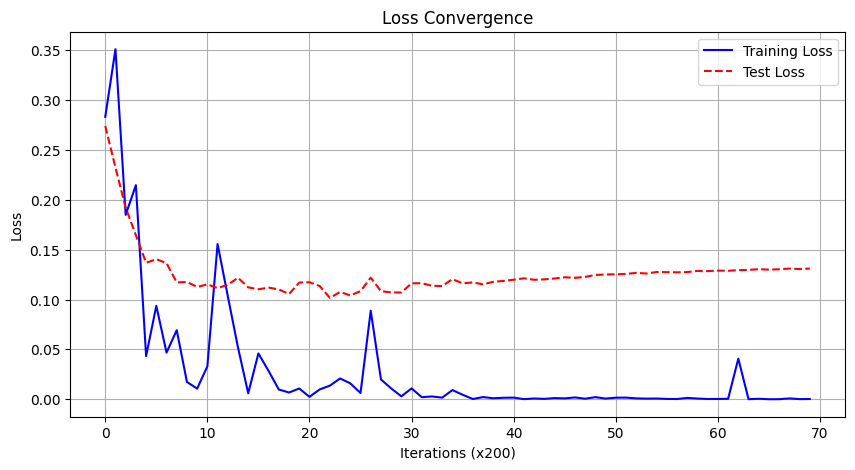

In [ ]:
best_model_momentum.plot_losses()

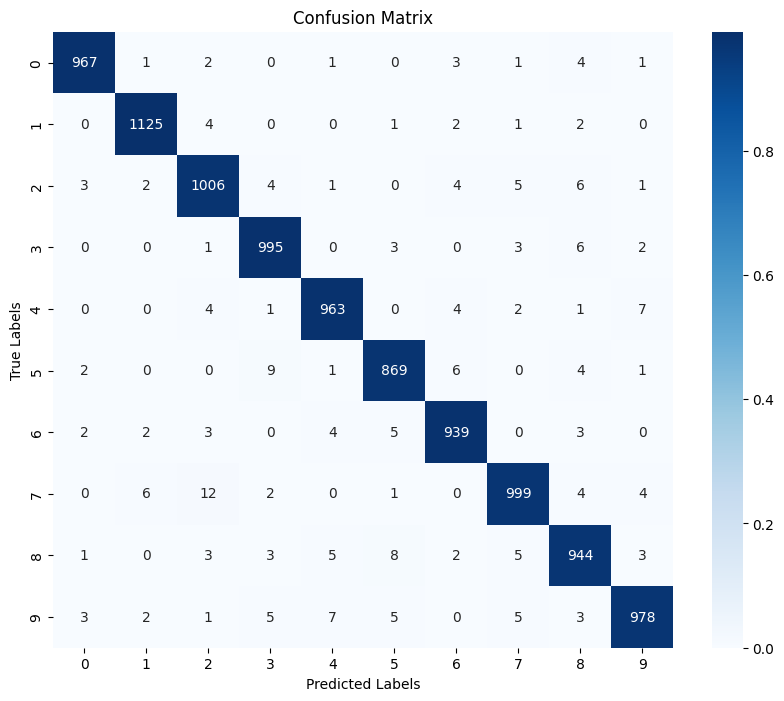

In [ ]:
best_model_momentum.plot_confusion_matrix(X_test, Y_test)

## RMSProp

In [ ]:
input_dim = 28 * 28
output_dim = 10

layers = [
    FNNLayer(input_dim, 500),
    ReLU(),
    FNNLayer(500, 250),
    ReLU(),
    FNNLayer(250, 100),
    ReLU(),
    FNNLayer(100, output_dim)
]

best_model_rmsprop = NN(layers)
optimizer = RMSProp()
loss = LogLoss()
best_model_rmsprop.compile(loss=loss, optimizer=optimizer)
best_model_rmsprop.fit(X_train, Y_train, X_test, Y_test)

Iteration: 200 Train Loss: 0.8611892463555653 Test Loss: 0.7039133869595239
Iteration: 400 Train Loss: 0.35707097285046063 Test Loss: 0.7108105935671143
Iteration: 600 Train Loss: 0.4380136647892557 Test Loss: 0.486649431615153
Iteration: 800 Train Loss: 0.7963917784223166 Test Loss: 0.5992141536867432
Epoch: 1 Mean Train Loss: 0.6623115042604161 Train Accuracy: 86.23%
Iteration: 1000 Train Loss: 0.22313052213516094 Test Loss: 0.8721529644762427
Iteration: 1200 Train Loss: 0.4857553856685233 Test Loss: 0.43115069396131156
Iteration: 1400 Train Loss: 0.39971691488116234 Test Loss: 0.4749583881452514
Iteration: 1600 Train Loss: 0.4414229664598167 Test Loss: 0.7655896421174432
Iteration: 1800 Train Loss: 0.8711488959623745 Test Loss: 0.5689467981365716
Epoch: 2 Mean Train Loss: 0.572174427857848 Train Accuracy: 86.96%
Iteration: 2000 Train Loss: 0.39883172775303977 Test Loss: 0.6084832773224301
Iteration: 2200 Train Loss: 0.4392633930447103 Test Loss: 0.5958015614513833
Iteration: 2400 Tr

In [ ]:
best_model_rmsprop.evaluate(X_train, Y_train, X_test, Y_test)

Train loss: 1.4270552521192934 Train accuracy: 70.71%
Test loss: 1.4923830521884554 Test accuracy: 70.84%

Confusion Matrix:
 [[ 759    0    0    0    0    0    1    0  220    0]
 [   0 1131    0    0    0    0    0    0    4    0]
 [   2   37  441    0    0    0    0    1  551    0]
 [   0   18    0  679    0    3    0    2  308    0]
 [   0   16    0    0  613    2    3    1  346    1]
 [   1    5    0    4    0  723    0    1  158    0]
 [   1   14    0    1    0    4  742    0  196    0]
 [   0   37    1    3    0    2    0  718  266    1]
 [   1   38    0    0    0    4    0    2  928    1]
 [   1   14    0    4    3    3    0    3  631  350]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.77      0.87       980
           1       0.86      1.00      0.93      1135
           2       1.00      0.43      0.60      1032
           3       0.98      0.67      0.80      1010
           4       1.00      0.62      0.77    

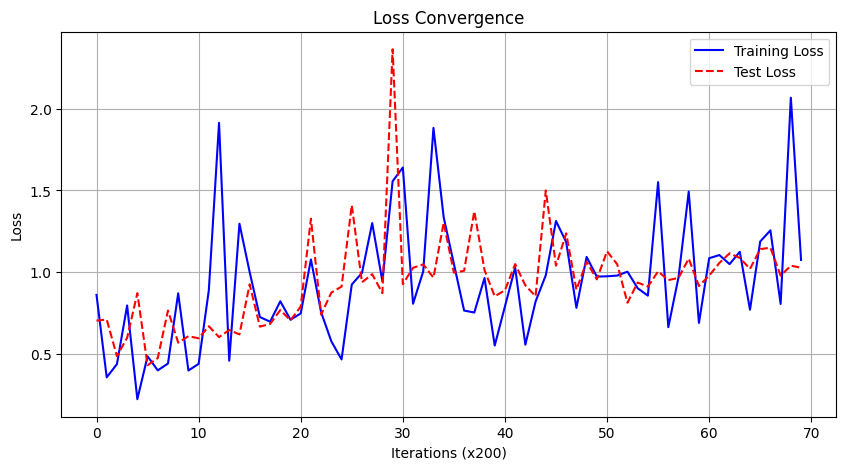

In [ ]:
best_model_rmsprop.plot_losses()

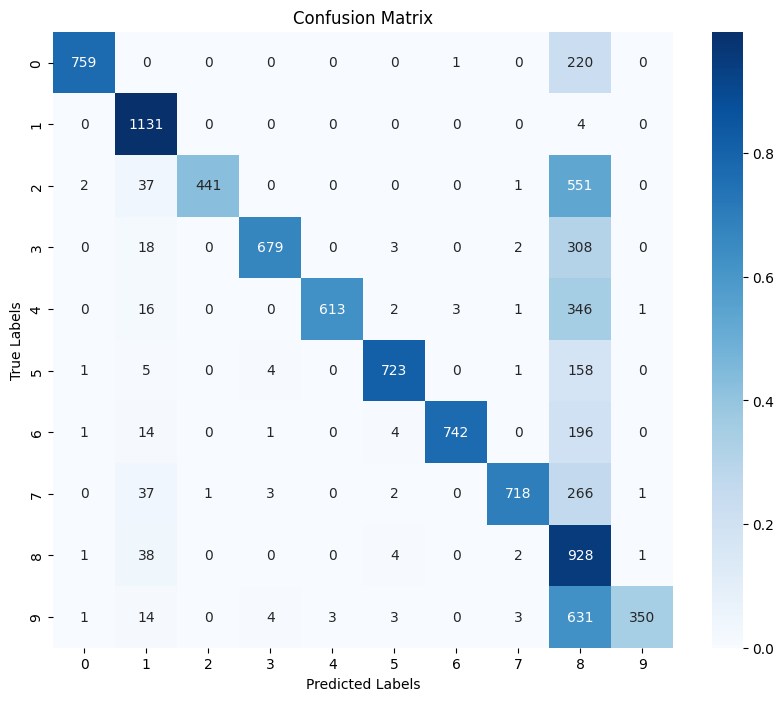

In [ ]:
best_model_rmsprop.plot_confusion_matrix(X_test, Y_test)

## Adam

In [ ]:
input_dim = 28 * 28
output_dim = 10

layers = [
    FNNLayer(input_dim, 500),
    ReLU(),
    FNNLayer(500, 250),
    ReLU(),
    FNNLayer(250, 100),
    ReLU(),
    FNNLayer(100, output_dim)
]

best_model_adam = NN(layers)
optimizer = Adam()
loss = LogLoss()
best_model_adam.compile(loss=loss, optimizer=optimizer)
best_model_adam.fit(X_train, Y_train, X_test, Y_test)

Iteration: 200 Train Loss: 0.2626578659015413 Test Loss: 0.3849439589897805
Iteration: 400 Train Loss: 0.2356629693344481 Test Loss: 0.4549075785197895
Iteration: 600 Train Loss: 0.31019765411731076 Test Loss: 0.3430033483875648
Iteration: 800 Train Loss: 0.24733567676926344 Test Loss: 0.2757730784214253
Epoch: 1 Mean Train Loss: 0.4339105918944163 Train Accuracy: 89.18%
Iteration: 1000 Train Loss: 0.30689332211144105 Test Loss: 0.2731464007045547
Iteration: 1200 Train Loss: 0.20397046367776933 Test Loss: 0.3769309562724609
Iteration: 1400 Train Loss: 0.2926237877439811 Test Loss: 0.3519468038054768
Iteration: 1600 Train Loss: 0.32132891775642125 Test Loss: 0.36277139073396836
Iteration: 1800 Train Loss: 0.19108151246371324 Test Loss: 0.37126781559592564
Epoch: 2 Mean Train Loss: 0.34407863935596317 Train Accuracy: 91.85%
Iteration: 2000 Train Loss: 0.18625849158469626 Test Loss: 0.3034613864325888
Iteration: 2200 Train Loss: 0.2077125864000273 Test Loss: 0.2562673641192234
Iteration: 

In [ ]:
best_model_adam.evaluate(X_train, Y_train, X_test, Y_test)

Train loss: 0.28485010562113333 Train accuracy: 93.32%
Test loss: 0.35776347232648775 Test accuracy: 92.61%

Confusion Matrix:
 [[ 931    0    1    0    0    0    1   47    0    0]
 [   3 1117    1    0    0    0    1   12    1    0]
 [  13    2  917    1    1    0    6   88    4    0]
 [  16    0    1  947    0    3    0   37    6    0]
 [   6    0    2    0  931    0    3   32    3    5]
 [  45    0    0    7    1  777    0   59    2    1]
 [  36    2    1    1    1    3  885   27    2    0]
 [   8    0    8    7   12    0    0  981    2   10]
 [   8    0    6    5    1    3    1   69  879    2]
 [  12    2    0    6   33    2    0   56    2  896]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.95      0.90       980
           1       0.99      0.98      0.99      1135
           2       0.98      0.89      0.93      1032
           3       0.97      0.94      0.95      1010
           4       0.95      0.95      0.95  

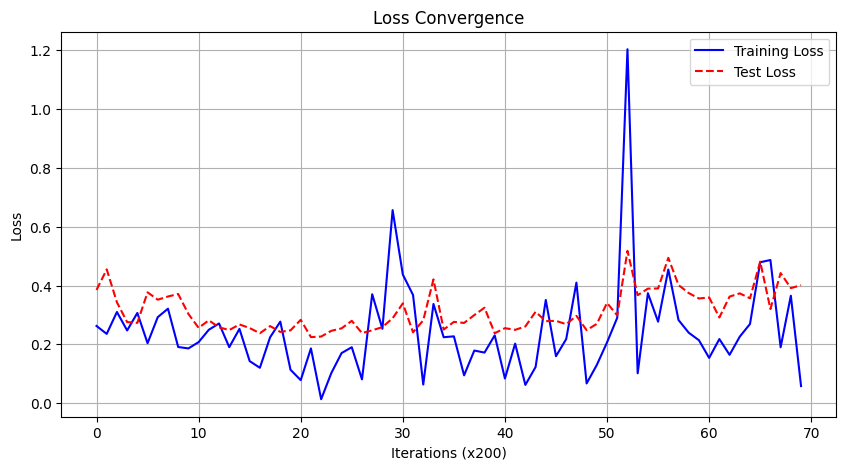

In [ ]:
best_model_adam.plot_losses()

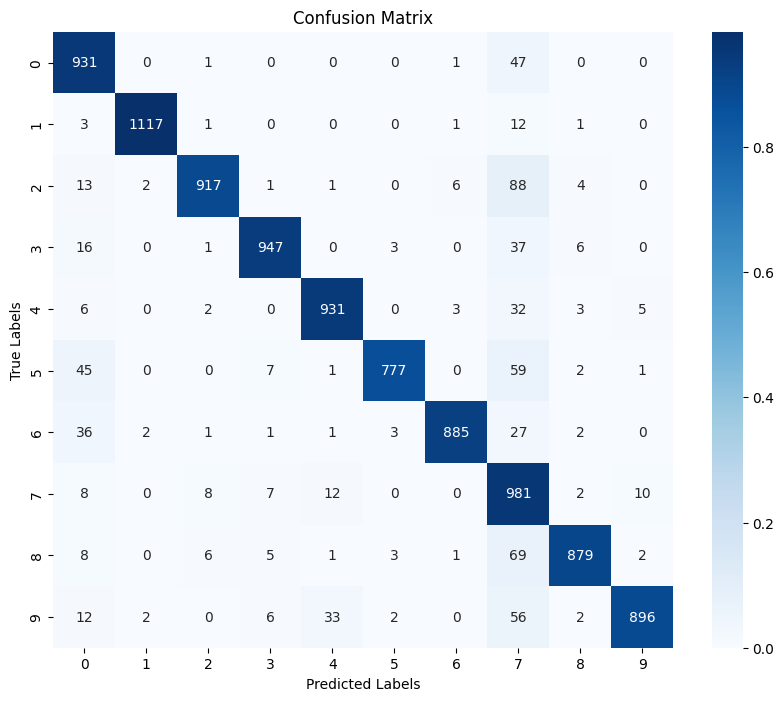

In [ ]:
best_model_adam.plot_confusion_matrix(X_test, Y_test)

## Comparing the 4 optimizers

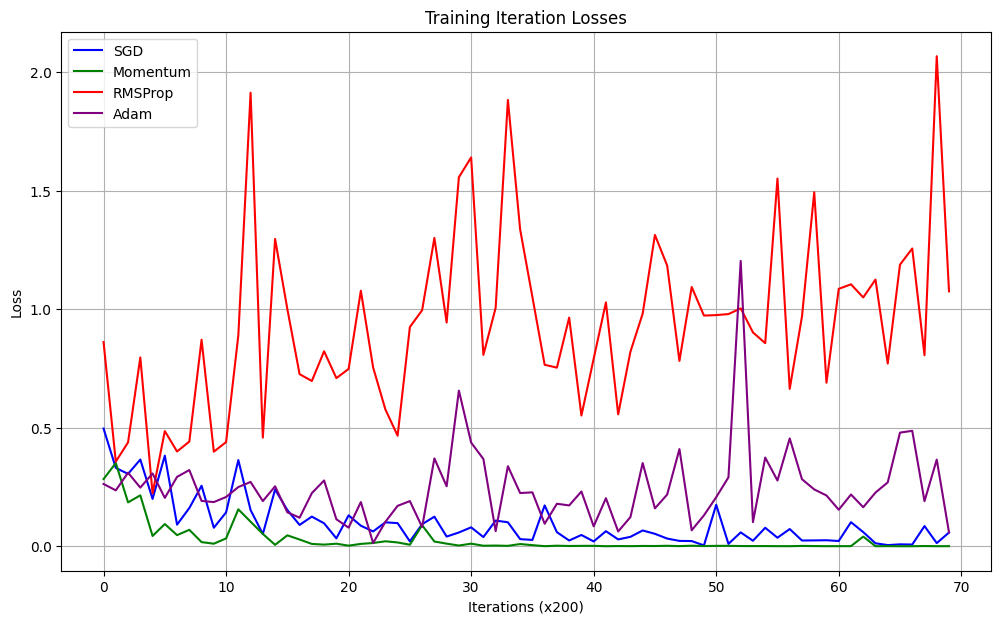

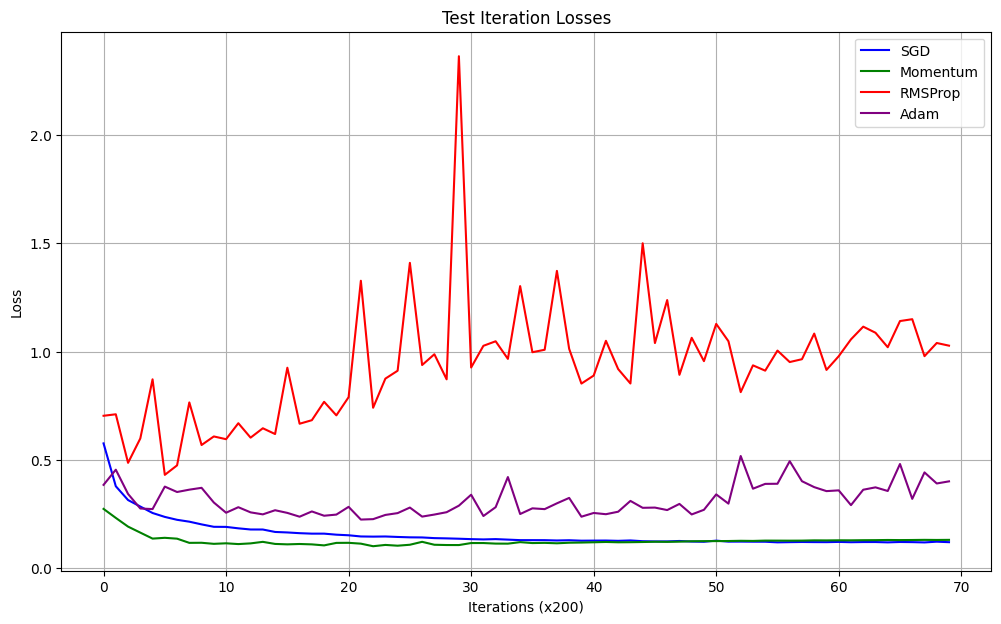

In [ ]:
import matplotlib.pyplot as plt

def plot_models_losses(models, labels, title, attribute):
    plt.figure(figsize=(12, 7))

    colors = ['blue', 'green', 'red', 'purple']

    for i, model in enumerate(models):
        losses = getattr(model, attribute)
        plt.plot(losses, label=labels[i], color=colors[i])

    plt.xlabel('Iterations (x200)')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

model1 = relu_model
model2 = best_model_momentum
model3 = best_model_rmsprop
model4 = best_model_adam

models = [model1, model2, model3, model4]
labels = ['SGD', 'Momentum', 'RMSProp', 'Adam']

# Plots training iteration losses
plot_models_losses(models, labels, 'Training Iteration Losses', 'iteration_losses')

# Plots test iteration losses
plot_models_losses(models, labels, 'Test Iteration Losses', 'iteration_test_losses')

Optimizer  | Test Accuracy | Train Accuracy | Train Loss| Test Loss
-------------------|------------------|---------------|------------|------------
      SGD |  96.91% |  99.58%| 0.0228 | 0.1212|
       Momentum | 97.85% | 100.00% | 0.0004 | 0.1321 |
       RMSProp |  70.84% | 70.71% | 1.4270 | 1,4924 |
       Adam  | 92.61% | 93.32% | 0.2848 | 0.3577

*   I am surprised by the results, because I expected RMSProp and Adam to perform better but I think the initializations were unfortunate for these two models in this run. Momentum and GD seem to be more stable optimizers also as we see less variance in the loss plots.
*   RMSProp and Adam are both hyperparameter sensitive as they have other beta, epsilon, etc. terms in their formulae. The values I chose might not have been suitable for this setup.
*   Momentum performs better than GD and leads to faster convergence as well. This is also expected because the moving average of past gradients acts as a kind of inertia. This inertia can help the optimizer to navigate through the optimization landscape and overcome small barriers.




# Performance with MSE Loss as criterion

We want to see if using Mean-squared error as the loss criterion for classification problems has a huge impact on the performance. We'll look at the base model architecture (ReLU) with the GD and Momentum optimizers.

## Best Model with SGD

In [ ]:
input_dim = 28 * 28
output_dim = 10

layers = [
    FNNLayer(input_dim, 500),
    ReLU(),
    FNNLayer(500, 250),
    ReLU(),
    FNNLayer(250, 100),
    ReLU(),
    FNNLayer(100, output_dim)
]

best_model_mse = NN(layers)
optimizer = SGD()
loss = MSE()
best_model_mse.compile(loss=loss, optimizer=optimizer)
best_model_mse.fit(X_train, Y_train, X_test, Y_test)

Iteration: 200 Train Loss: 0.7639431459233281 Test Loss: 0.786340076958693
Iteration: 400 Train Loss: 0.6173905654223258 Test Loss: 0.6315594198813431
Iteration: 600 Train Loss: 0.4696360210640014 Test Loss: 0.4818534525108481
Iteration: 800 Train Loss: 0.4556449154616644 Test Loss: 0.3647332202124966
Epoch: 1 Mean Train Loss: 0.597284572181989 Train Accuracy: 57.05%
Iteration: 1000 Train Loss: 0.2833996243166443 Test Loss: 0.2795598274564075
Iteration: 1200 Train Loss: 0.22323868131738006 Test Loss: 0.2287074202432093
Iteration: 1400 Train Loss: 0.21617243257778918 Test Loss: 0.19907003069065093
Iteration: 1600 Train Loss: 0.16603812966092046 Test Loss: 0.17950475417732326
Iteration: 1800 Train Loss: 0.18764176308506986 Test Loss: 0.16516704648111896
Epoch: 2 Mean Train Loss: 0.21713282376809714 Train Accuracy: 87.57%
Iteration: 2000 Train Loss: 0.13492070611817913 Test Loss: 0.1550719964994174
Iteration: 2200 Train Loss: 0.11147184044004207 Test Loss: 0.14666179367279797
Iteration: 2

In [ ]:
best_model_mse.evaluate(X_train, Y_train, X_test, Y_test)

Train loss: 0.05435408199843766 Train accuracy: 96.85%
Test loss: 0.06934993816712287 Test accuracy: 95.52%

Confusion Matrix:
 [[ 967    0    1    1    0    4    4    0    2    1]
 [   0 1114    7    2    1    1    4    1    5    0]
 [   8    0  976    7    3    5    9    7   14    3]
 [   0    0   11  962    0   11    1    9   12    4]
 [   2    0    4    1  934    0   10    4    2   25]
 [   3    1    0   11    4  843    8    2   17    3]
 [   7    3    3    0    7   11  921    1    5    0]
 [   1    8   22    6    5    2    0  963    1   20]
 [   5    2    7    7    5    8    5    6  926    3]
 [   6    5    4   11   13    4    1   10    9  946]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.94      0.95      0.94      1032
           3       0.95      0.95      0.95      1010
           4       0.96      0.95      0.96  

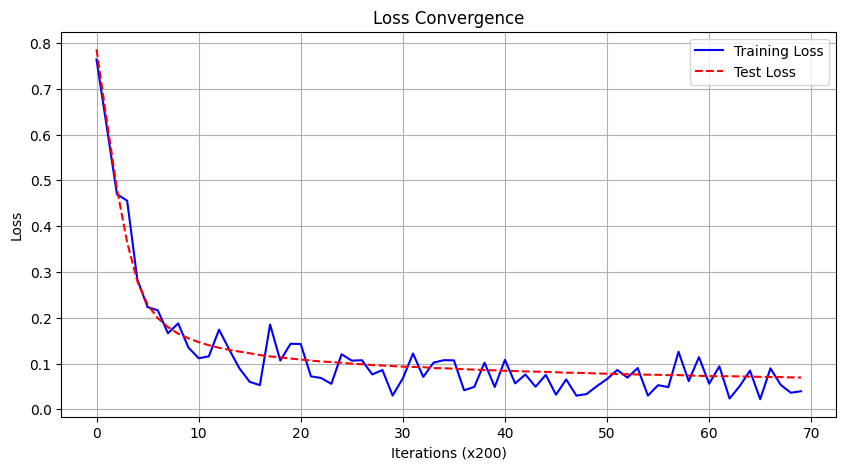

In [ ]:
best_model_mse.plot_losses()

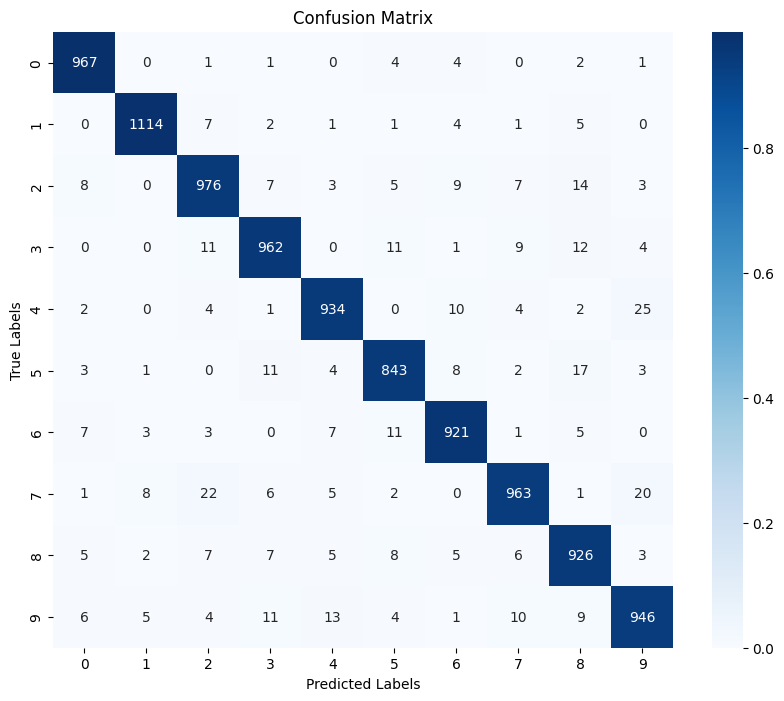

In [ ]:
best_model_mse.plot_confusion_matrix(X_test, Y_test)

## Best Model with Momentum

In [ ]:
input_dim = 28 * 28
output_dim = 10

layers = [
    FNNLayer(input_dim, 500),
    ReLU(),
    FNNLayer(500, 250),
    ReLU(),
    FNNLayer(250, 100),
    ReLU(),
    FNNLayer(100, output_dim)
]

best_model_mse_momentum = NN(layers)
optimizer = Momentum()
loss = MSE()
best_model_mse_momentum.compile(loss=loss, optimizer=optimizer)
best_model_mse_momentum.fit(X_train, Y_train, X_test, Y_test)

Iteration: 200 Train Loss: 0.1970906314136762 Test Loss: 0.1805879480748743
Iteration: 400 Train Loss: 0.17197580855856368 Test Loss: 0.12912247218147627
Iteration: 600 Train Loss: 0.07667621654166826 Test Loss: 0.10589176116273526
Iteration: 800 Train Loss: 0.20201804926609157 Test Loss: 0.09189451963171143
Epoch: 1 Mean Train Loss: 0.19116738321512441 Train Accuracy: 86.98%
Iteration: 1000 Train Loss: 0.11846449367061995 Test Loss: 0.08682049771885827
Iteration: 1200 Train Loss: 0.08658912464911242 Test Loss: 0.08134716743986997
Iteration: 1400 Train Loss: 0.07981202378648175 Test Loss: 0.07847022954196056
Iteration: 1600 Train Loss: 0.13479868614625845 Test Loss: 0.07130267924571303
Iteration: 1800 Train Loss: 0.05162109883333352 Test Loss: 0.07370463489524325
Epoch: 2 Mean Train Loss: 0.0723230574914483 Train Accuracy: 95.46%
Iteration: 2000 Train Loss: 0.038583662274235764 Test Loss: 0.06747866685555669
Iteration: 2200 Train Loss: 0.05013087989267662 Test Loss: 0.0642704736385103


In [ ]:
best_model_mse_momentum.evaluate(X_train, Y_train, X_test, Y_test)

Train loss: 0.009374661613132869 Train accuracy: 99.52%
Test loss: 0.0449472018655512 Test accuracy: 97.20%

Confusion Matrix:
 [[ 970    1    2    1    0    0    2    1    3    0]
 [   0 1126    2    0    0    1    2    1    3    0]
 [   3    3 1000    4    2    0    3    9    8    0]
 [   0    0    2  981    0    9    1    7    5    5]
 [   2    0    7    1  945    1    7    5    6    8]
 [   3    1    1    5    1  872    4    2    3    0]
 [   5    2    2    1    6    8  932    0    2    0]
 [   0    4    8    3    0    1    1 1003    3    5]
 [   2    0    3    9    2   10    1    7  935    5]
 [   3    3    3    7    8    4    1   18    6  956]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.98      0.96      0.97  

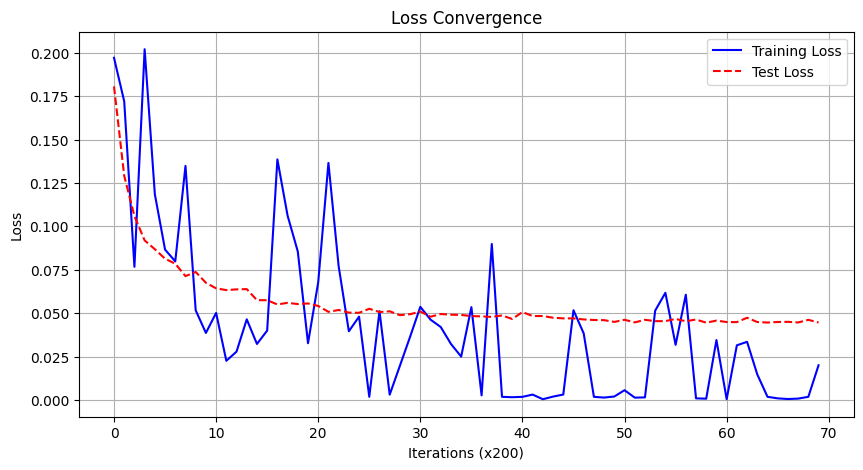

In [ ]:
best_model_mse_momentum.plot_losses()

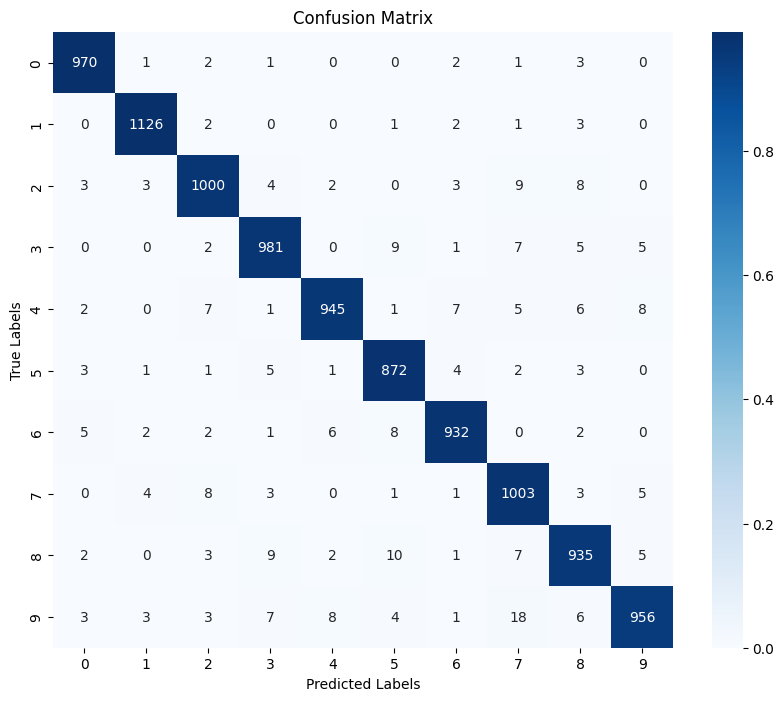

In [ ]:
best_model_mse_momentum.plot_confusion_matrix(X_test, Y_test)

## Comparison

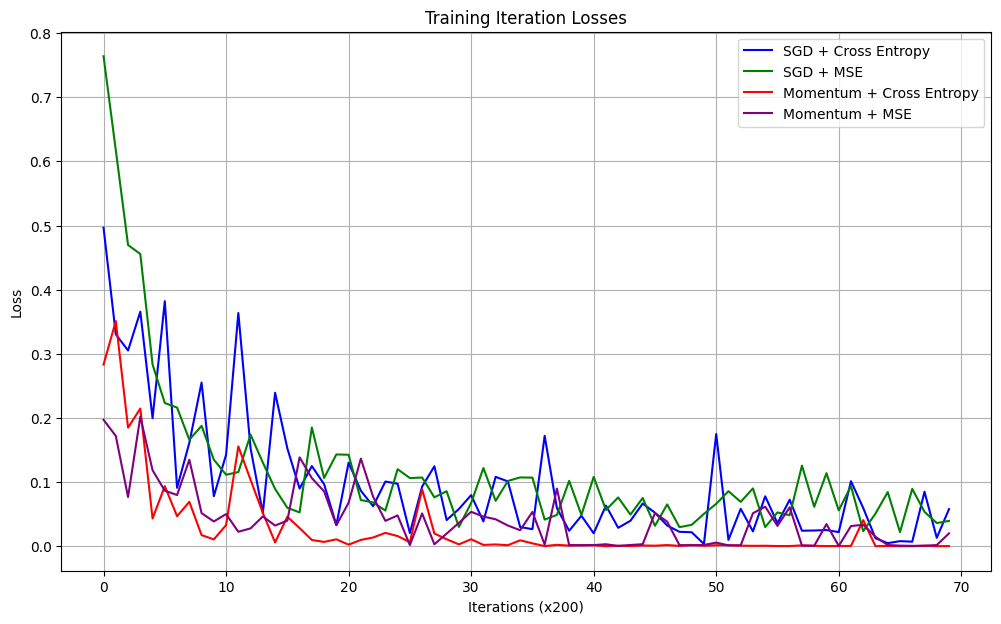

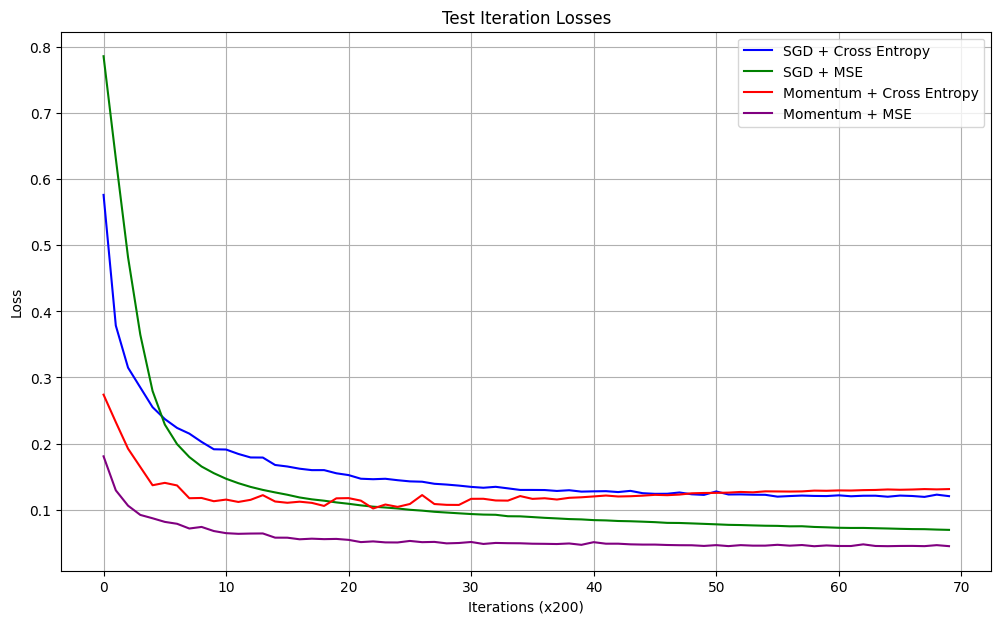

In [ ]:
import matplotlib.pyplot as plt

def plot_models_losses(models, labels, title, attribute):
    plt.figure(figsize=(12, 7))

    colors = ['blue', 'green', 'red', 'purple']

    for i, model in enumerate(models):
        losses = getattr(model, attribute)
        plt.plot(losses, label=labels[i], color=colors[i])

    plt.xlabel('Iterations (x200)')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

model1 = relu_model
model2 = best_model_mse
model3 = best_model_momentum
model4 = best_model_mse_momentum

models = [model1, model2, model3, model4]
labels = ['SGD + Cross Entropy', 'SGD + MSE', 'Momentum + Cross Entropy', 'Momentum + MSE']

# Plots training iteration losses
plot_models_losses(models, labels, 'Training Iteration Losses', 'iteration_losses')

# Plots test iteration losses
plot_models_losses(models, labels, 'Test Iteration Losses', 'iteration_test_losses')

## Observations

Configuration | Test Accuracy | Train Accuracy | Train Loss| Test Loss
-------------------|------------------|---------------|------------|------------
      SGD + Log Loss |  96.91% |  99.58%| 0.0288 | 0.1212|
       SGD + MSE | 95.52% | 96.85% | 0.05435 | 0.0693 |
       Momentum + Log Loss |  97.85% | 100.00% | 0.00037 | 0.1320 |
       Momentum +  MSE | 97.20% | 99.52% | 0.0094 | 0.0449

We make two important observations:
*   The models trained with Cross Entropy as the loss criterion outperform their counterparts trained with mean-sqaured error.
*   The models trained with MSE as the loss criterion saturate to lower loss values.

We can infer that the Cross Entropy loss is more critical of misclassifications, which is one of the important factors for it leading to better performance. This can be concluded from the fact that the Cross entropy models have higher accuracy even though the loss value observed is more.

Also, the MSE criterion leads to more stable loss plots which can probably linked with the relative smoothness of the loss function itself.






# PyTorch vs From Scratch Implementation Analysis

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the NN architecture
class PyTorchNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PyTorchNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 500)
        self.fc2 = nn.Linear(500, 250)
        self.fc3 = nn.Linear(250, 100)
        self.fc4 = nn.Linear(100, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)  # No activation here, CrossEntropyLoss adds softmax

model = PyTorchNN(input_dim=28*28, output_dim=10)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Training function
def train_model(model, train_loader, test_loader, epochs=15, log_interval=200):
    iteration_losses = []
    iteration_test_losses = []
    history = []

    model.train()
    iteration_counter = 0

    for epoch in range(epochs):
        tr_loss_epoch, tr_acc = 0, 0
        for batch_idx, (X_t, Y_t) in enumerate(train_loader):
            optimizer.zero_grad()
            preds = model(X_t.view(X_t.size(0), -1))
            loss = criterion(preds, Y_t)
            loss.backward()
            optimizer.step()

            tr_loss_epoch += loss.item()
            tr_acc += (preds.argmax(1) == Y_t).float().mean().item()

            iteration_counter += 1
            if iteration_counter % log_interval == 0:
                with torch.no_grad():
                    te_loss = sum(criterion(model(X_te.view(X_te.size(0), -1)), Y_te) for X_te, Y_te in test_loader)
                    iteration_test_losses.append(te_loss/len(test_loader))
                iteration_losses.append(loss.item())
                print(f"Iteration: {iteration_counter} Train Loss: {loss.item()} Test Loss: {te_loss/len(test_loader)}")

        mean_tr_loss_epoch = tr_loss_epoch / len(train_loader)
        mean_tr_acc = tr_acc / len(train_loader)
        history.append({
            "Epoch": epoch,
            "Train Loss": mean_tr_loss_epoch,
            "Train Accuracy": mean_tr_acc
        })
        print(f"Epoch: {epoch+1} Mean Train Loss: {mean_tr_loss_epoch} Train Accuracy: {mean_tr_acc * 100:.2f}%")

    return iteration_losses, iteration_test_losses, history


def evaluate_model(model, train_loader, test_loader, criterion):
    model.eval()


    train_loss, train_correct, train_total = 0.0, 0, 0
    for X, Y in train_loader:
        outputs = model(X.view(X.size(0), -1))
        loss = criterion(outputs, Y)
        train_loss += loss.item() * X.size(0)
        _, predicted = outputs.max(1)
        train_correct += (predicted == Y).sum().item()
        train_total += Y.size(0)

    train_loss /= train_total
    train_accuracy = train_correct / train_total


    test_loss, test_correct, test_total = 0.0, 0, 0
    for X, Y in test_loader:
        outputs = model(X.view(X.size(0), -1))
        loss = criterion(outputs, Y)
        test_loss += loss.item() * X.size(0)
        _, predicted = outputs.max(1)
        test_correct += (predicted == Y).sum().item()
        test_total += Y.size(0)

    test_loss /= test_total
    test_accuracy = test_correct / test_total

    print(f"Train loss: {train_loss:.4f} Train accuracy: {train_accuracy*100:.2f}%")
    print(f"Test loss: {test_loss:.4f} Test accuracy: {test_accuracy*100:.2f}%")

    test_preds = torch.cat([model(X.view(X.size(0), -1)) for X, _ in test_loader])
    test_targets = torch.cat([Y for _, Y in test_loader])
    cm = confusion_matrix(test_targets.numpy(), test_preds.argmax(1).numpy())
    cr = classification_report(test_targets.numpy(), test_preds.argmax(1).numpy())
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", cr)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(iteration_losses, label='Training Loss', color='blue')
    plt.plot(iteration_test_losses, label='Test Loss', color='red', linestyle='--')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Loss Convergence')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float), torch.tensor(Y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float), torch.tensor(Y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

iteration_losses, iteration_test_losses, history = train_model(model, train_loader, test_loader)

Iteration: 200 Train Loss: 0.06082472577691078 Test Loss: 0.22181178629398346
Iteration: 400 Train Loss: 0.04833768680691719 Test Loss: 0.17600177228450775
Iteration: 600 Train Loss: 0.103426992893219 Test Loss: 0.14798253774642944
Iteration: 800 Train Loss: 0.16304656863212585 Test Loss: 0.13436774909496307
Epoch: 1 Mean Train Loss: 0.22737133383615885 Train Accuracy: 93.20%
Iteration: 1000 Train Loss: 0.03831842541694641 Test Loss: 0.14795252680778503
Iteration: 1200 Train Loss: 0.15561886131763458 Test Loss: 0.13509203493595123
Iteration: 1400 Train Loss: 0.17523612082004547 Test Loss: 0.17890894412994385
Iteration: 1600 Train Loss: 0.11719272285699844 Test Loss: 0.17084895074367523
Iteration: 1800 Train Loss: 0.10489985346794128 Test Loss: 0.12421727925539017
Epoch: 2 Mean Train Loss: 0.09823897467064324 Train Accuracy: 97.03%
Iteration: 2000 Train Loss: 0.04964468628168106 Test Loss: 0.12013204395771027
Iteration: 2200 Train Loss: 0.0065956139005720615 Test Loss: 0.134501069784164

Train loss: 0.0122 Train accuracy: 99.63%
Test loss: 0.1311 Test accuracy: 97.82%

Confusion Matrix:
 [[ 970    1    0    0    1    2    3    2    1    0]
 [   0 1127    3    0    0    0    2    1    2    0]
 [   7    6 1000    2    3    1    1    5    6    1]
 [   0    0    2  995    0    6    0    2    5    0]
 [   0    0    3    1  966    0    6    2    0    4]
 [   3    0    0    8    2  869    3    2    5    0]
 [   2    2    0    1    3    6  941    0    3    0]
 [   0    9    8    2    3    0    1 1001    2    2]
 [   3    2    2    3    2    3    1    7  949    2]
 [   1    4    1    7   18    3    0    8    3  964]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.97      0.98      0.98       982
           5     

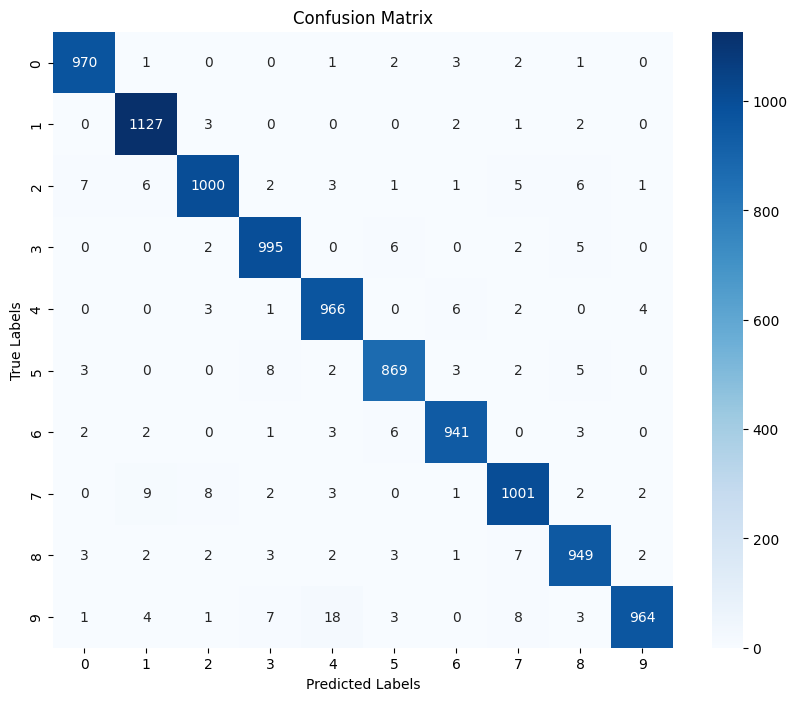

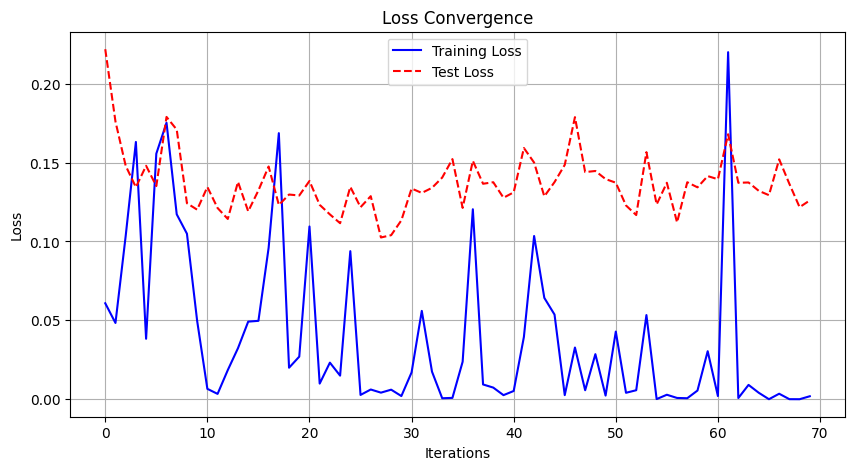

In [ ]:
evaluate_model(model, train_loader, test_loader, criterion)

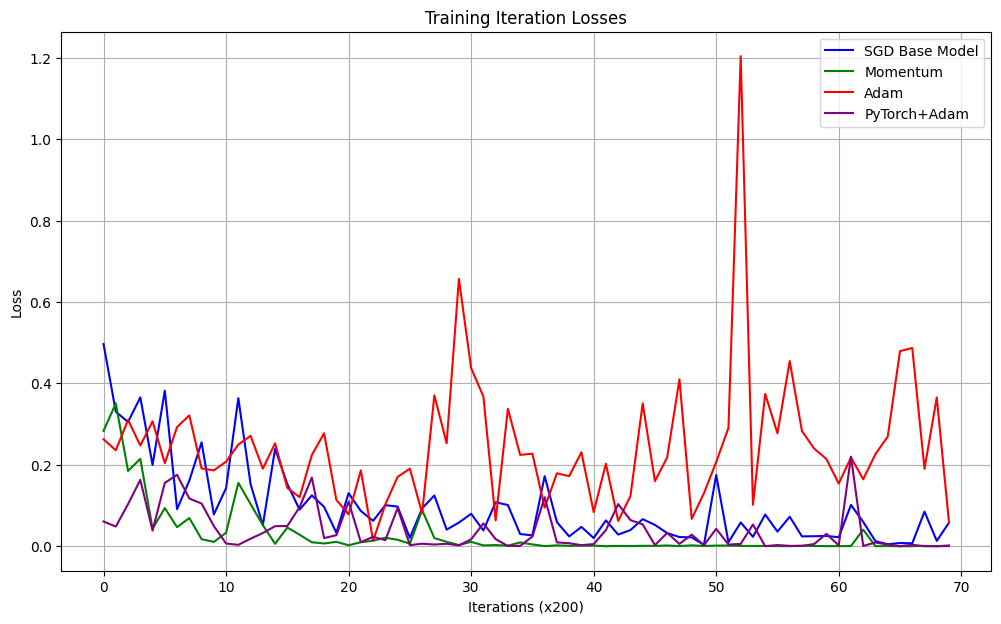

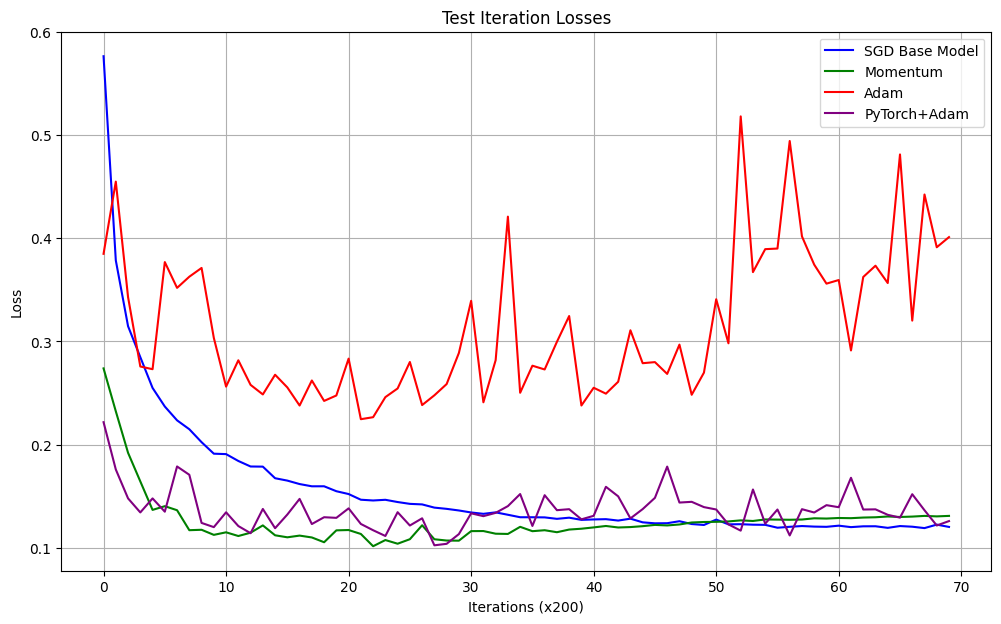

In [ ]:
import matplotlib.pyplot as plt

def plot_models_losses(losses_list, labels, title):
    plt.figure(figsize=(12, 7))

    colors = ['blue', 'green', 'red', 'purple']

    for i, losses in enumerate(losses_list):
        plt.plot(losses, label=labels[i], color=colors[i])

    plt.xlabel('Iterations (x200)')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

model1 = relu_model
model2 = best_model_momentum
model3 = best_model_adam


training_losses = [
    model1.iteration_losses,
    model2.iteration_losses,
    model3.iteration_losses,
    iteration_losses
]

test_losses = [
    model1.iteration_test_losses,
    model2.iteration_test_losses,
    model3.iteration_test_losses,
    iteration_test_losses
]

labels = ['SGD Base Model', 'Momentum', 'Adam', 'PyTorch+Adam']

# Plots training iteration losses
plot_models_losses(training_losses, labels, 'Training Iteration Losses')

# Plots test iteration losses
plot_models_losses(test_losses, labels, 'Test Iteration Losses')


## Observations

The training is much faster when we use the PyTorch implementation. This version also gives the best performance among all the models we have tried so far. PyTorch has optimized low-level implementations for many tensor operations. These optimizations might include more efficient memory access patterns, fused operations, and other tricks that a manual numpy implementation might not take advantage of. PyTorch provides automatic differentiation, which ensures that the gradients are computed correctly and efficiently. Implementing backpropagation manually in numpy can be error-prone and might not be as optimized as PyTorch's autograd. Here is a summary to compare results:

Configuration  | Test Accuracy | Train Accuracy | Train Loss| Test Loss
-------------------|------------------|---------------|------------|------------
      SGD|  96.91% |  99.58%| 0.0228 | 0.1212|
       Momentum| 97.85% | 100.00% | 0.00037 | 0.1320 |
       NumPy+Adam|  92.61% | 93.32% | 0.2848 | 0.3577 |
       PyTorch+Adam  | 97.82% | 99.63% | 0.0122 | 0.1311 |

Suprisingly, the momentum implementation outperforms the PyTorch implementation of Adam as well. Some research shows that momentum based gradient descent introduces a certain level of implicit noise into the weight updates. This noise can act as a form of regularization, which can sometimes help in generalization.[[1]](https://arxiv.org/abs/2201.05405)[[2]](https://arxiv.org/abs/2110.03891) Adam, with its adaptive learning rates for each parameter, can sometimes overfit to the training data, especially if the model capacity is high and dropout or other regularization methods are not used.

# Weight Decay Effects

## Weight Decay 0.5

### SGD

In [18]:
input_dim = 28 * 28
output_dim = 10

layers = [
    FNNLayer(input_dim, 500, weight_decay = 0.5),
    ReLU(),
    FNNLayer(500, 250, weight_decay = 0.5),
    ReLU(),
    FNNLayer(250, 100, weight_decay = 0.5),
    ReLU(),
    FNNLayer(100, output_dim, weight_decay = 0.5)
]

sgd_model_halfalpha = NN(layers)
optimizer = SGD()
loss = LogLoss()
sgd_model_halfalpha.compile(loss=loss, optimizer=optimizer)
sgd_model_halfalpha.fit(X_train, Y_train, X_test, Y_test)

Iteration: 200 Train Loss: 2.3017919715727944 Test Loss: 2.3017244501048695
Iteration: 400 Train Loss: 2.3024163265998636 Test Loss: 2.302314815295173
Iteration: 600 Train Loss: 2.3031309135419322 Test Loss: 2.3022845333623443
Iteration: 800 Train Loss: 2.3018953289929494 Test Loss: 2.302310788233524
Epoch: 1 Mean Train Loss: 2.2929790709290208 Train Accuracy: 16.45%
Iteration: 1000 Train Loss: 2.3017447394304726 Test Loss: 2.3023281484590545
Iteration: 1200 Train Loss: 2.3028537809799667 Test Loss: 2.302278164931032
Iteration: 1400 Train Loss: 2.3029433094736302 Test Loss: 2.3022947300001064
Iteration: 1600 Train Loss: 2.3023761139010404 Test Loss: 2.302350756875167
Iteration: 1800 Train Loss: 2.302936908270609 Test Loss: 2.3024108006116917
Epoch: 2 Mean Train Loss: 2.3023601550211237 Train Accuracy: 11.18%
Iteration: 2000 Train Loss: 2.302970889131903 Test Loss: 2.30235481137353
Iteration: 2200 Train Loss: 2.303656013843194 Test Loss: 2.302281349213606
Iteration: 2400 Train Loss: 2.3

In [19]:
sgd_model_halfalpha.evaluate(X_train, Y_train, X_test, Y_test)

Train loss: 2.3023430208775486 Train accuracy: 10.44%
Test loss: 2.3023533700948295 Test accuracy: 10.28%

Confusion Matrix:
 [[   0    0    0    0    0    0    0  980    0    0]
 [   0    0    0    0    0    0    0 1135    0    0]
 [   0    0    0    0    0    0    0 1032    0    0]
 [   0    0    0    0    0    0    0 1010    0    0]
 [   0    0    0    0    0    0    0  982    0    0]
 [   0    0    0    0    0    0    0  892    0    0]
 [   0    0    0    0    0    0    0  958    0    0]
 [   0    0    0    0    0    0    0 1028    0    0]
 [   0    0    0    0    0    0    0  974    0    0]
 [   0    0    0    0    0    0    0 1009    0    0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


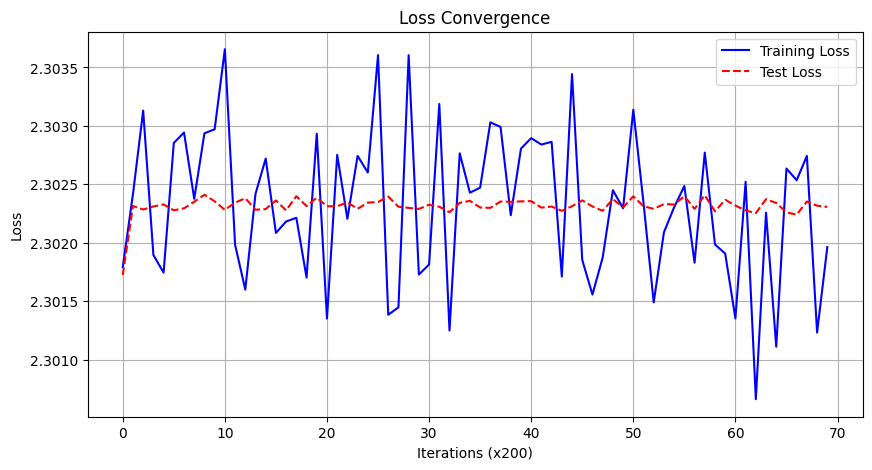

In [20]:
sgd_model_halfalpha.plot_losses()

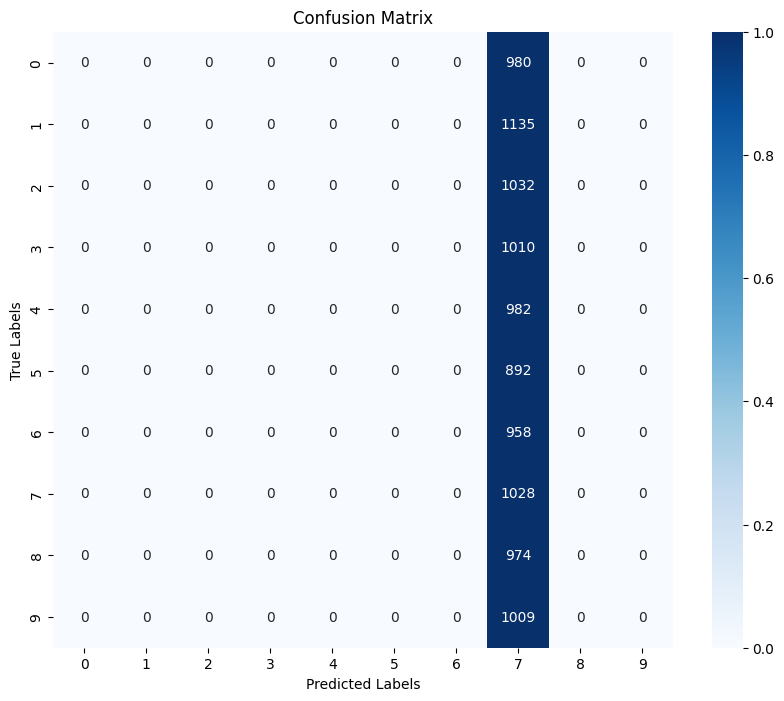

In [21]:
sgd_model_halfalpha.plot_confusion_matrix(X_test, Y_test)

### Momentum

In [22]:
input_dim = 28 * 28
output_dim = 10

layers = [
    FNNLayer(input_dim, 500, weight_decay = 0.5),
    ReLU(),
    FNNLayer(500, 250, weight_decay = 0.5),
    ReLU(),
    FNNLayer(250, 100, weight_decay = 0.5),
    ReLU(),
    FNNLayer(100, output_dim, weight_decay = 0.5)
]

momentum_model_halfalpha = NN(layers)
optimizer = Momentum()
loss = LogLoss()
momentum_model_halfalpha.compile(loss=loss, optimizer=optimizer)
momentum_model_halfalpha.fit(X_train, Y_train, X_test, Y_test)

Iteration: 200 Train Loss: 2.3028357288744203 Test Loss: 2.302156660144446
Iteration: 400 Train Loss: 2.3026408000847898 Test Loss: 2.3024215819876974
Iteration: 600 Train Loss: 2.302070425932069 Test Loss: 2.302229776765459
Iteration: 800 Train Loss: 2.3011183873611447 Test Loss: 2.3024022742762194
Epoch: 1 Mean Train Loss: 2.3019840449955633 Train Accuracy: 11.06%
Iteration: 1000 Train Loss: 2.3031027044479275 Test Loss: 2.302523207132461
Iteration: 1200 Train Loss: 2.301694761205412 Test Loss: 2.302426776972655
Iteration: 1400 Train Loss: 2.3028822432020304 Test Loss: 2.30213394825567
Iteration: 1600 Train Loss: 2.303119232528476 Test Loss: 2.3023716967009307
Iteration: 1800 Train Loss: 2.3011491881546022 Test Loss: 2.3021800933645067
Epoch: 2 Mean Train Loss: 2.3024167216964835 Train Accuracy: 10.48%
Iteration: 2000 Train Loss: 2.301398027581473 Test Loss: 2.302325313190977
Iteration: 2200 Train Loss: 2.3027913291734046 Test Loss: 2.3024811653075585
Iteration: 2400 Train Loss: 2.30

In [23]:
momentum_model_halfalpha.evaluate(X_train, Y_train, X_test, Y_test)

Train loss: 2.3025131587720344 Train accuracy: 11.24%
Test loss: 2.302426730233801 Test accuracy: 11.35%

Confusion Matrix:
 [[   0  980    0    0    0    0    0    0    0    0]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   0 1032    0    0    0    0    0    0    0    0]
 [   0 1010    0    0    0    0    0    0    0    0]
 [   0  982    0    0    0    0    0    0    0    0]
 [   0  892    0    0    0    0    0    0    0    0]
 [   0  958    0    0    0    0    0    0    0    0]
 [   0 1028    0    0    0    0    0    0    0    0]
 [   0  974    0    0    0    0    0    0    0    0]
 [   0 1009    0    0    0    0    0    0    0    0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.11      1.00      0.20      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


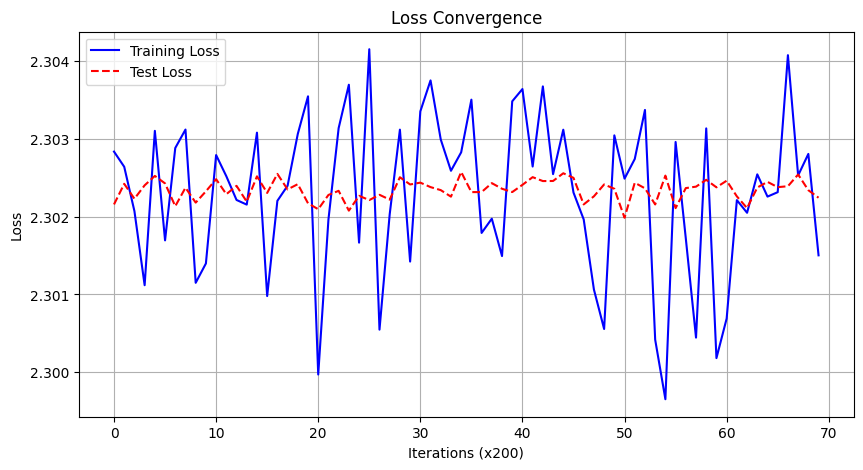

In [24]:
momentum_model_halfalpha.plot_losses()

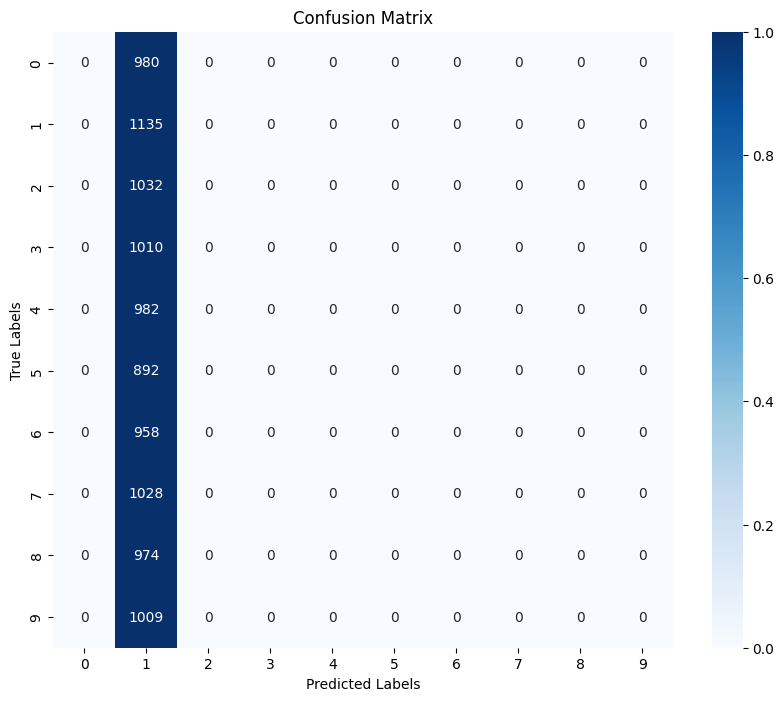

In [25]:
momentum_model_halfalpha.plot_confusion_matrix(X_test, Y_test)

### Conclusion
Such a high regularization term doesn't let the models learn at all. Most didgits are classified as either 1 (Momentum) or 7 (GD), showing the bias introduced by the regularization term in the model.

## Weight Decay 0.1

### SGD

In [29]:
input_dim = 28 * 28
output_dim = 10

layers = [
    FNNLayer(input_dim, 500, weight_decay = 0.1),
    ReLU(),
    FNNLayer(500, 250, weight_decay = 0.1),
    ReLU(),
    FNNLayer(250, 100, weight_decay = 0.1),
    ReLU(),
    FNNLayer(100, output_dim, weight_decay = 0.1)
]

sgd_model_1by10alpha = NN(layers)
optimizer = SGD()
loss = LogLoss()
sgd_model_1by10alpha.compile(loss=loss, optimizer=optimizer)
sgd_model_1by10alpha.fit(X_train, Y_train, X_test, Y_test)

Iteration: 200 Train Loss: 1.367842782262861 Test Loss: 1.3121800212745725
Iteration: 400 Train Loss: 1.3229758630084394 Test Loss: 1.306041785583772
Iteration: 600 Train Loss: 1.4534855568941418 Test Loss: 1.3861890767250347
Iteration: 800 Train Loss: 1.4995705179141627 Test Loss: 1.451012067373891
Epoch: 1 Mean Train Loss: 1.4329701540684647 Train Accuracy: 66.94%
Iteration: 1000 Train Loss: 1.4163052282825659 Test Loss: 1.492545427602849
Iteration: 1200 Train Loss: 1.5545758052792824 Test Loss: 1.5281121003488751
Iteration: 1400 Train Loss: 1.488846803071123 Test Loss: 1.5338520274881131
Iteration: 1600 Train Loss: 1.5935913840145028 Test Loss: 1.546415191576921
Iteration: 1800 Train Loss: 1.7164191432838272 Test Loss: 1.552775285541667
Epoch: 2 Mean Train Loss: 1.5380085006845625 Train Accuracy: 48.71%
Iteration: 2000 Train Loss: 1.5873631491164826 Test Loss: 1.5556573089504095
Iteration: 2200 Train Loss: 1.5171323246188277 Test Loss: 1.563399133041899
Iteration: 2400 Train Loss: 1

In [30]:
sgd_model_1by10alpha.evaluate(X_train, Y_train, X_test, Y_test)

Train loss: 1.5462759224615779 Train accuracy: 42.20%
Test loss: 1.5464187583510585 Test accuracy: 41.62%

Confusion Matrix:
 [[ 946    4    2    2    0    0   23    3    0    0]
 [   0 1128    1    1    0    0    5    0    0    0]
 [  47  123   11    6    4    0  808   33    0    0]
 [ 250  325   29  227   13    0   91   75    0    0]
 [  17   31    1    0    6    0   35  892    0    0]
 [ 460  200    7   74   13    0   50   88    0    0]
 [  32   29    2    0    0    0  889    6    0    0]
 [   4   60    0    0    0    0    9  955    0    0]
 [ 156  365   30  194   34    0   70  125    0    0]
 [  19   22    0    6    1    0    7  954    0    0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.97      0.65       980
           1       0.49      0.99      0.66      1135
           2       0.13      0.01      0.02      1032
           3       0.45      0.22      0.30      1010
           4       0.08      0.01      0.01    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


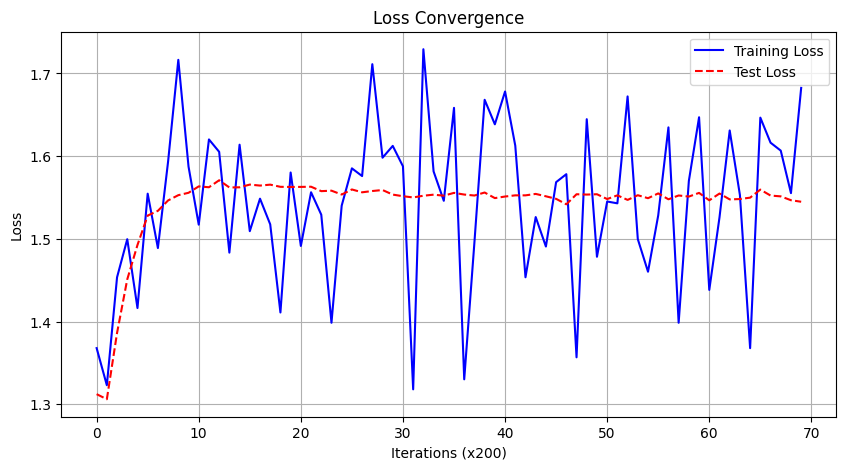

In [31]:
sgd_model_1by10alpha.plot_losses()

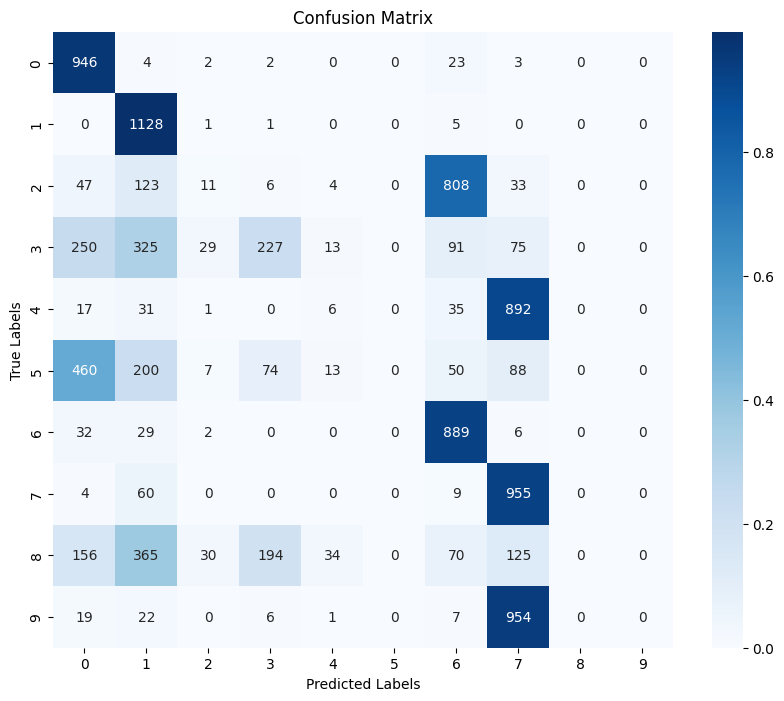

In [32]:
sgd_model_1by10alpha.plot_confusion_matrix(X_test, Y_test)

### Momentum

In [33]:
input_dim = 28 * 28
output_dim = 10

layers = [
    FNNLayer(input_dim, 500, weight_decay = 0.1),
    ReLU(),
    FNNLayer(500, 250, weight_decay = 0.1),
    ReLU(),
    FNNLayer(250, 100, weight_decay = 0.1),
    ReLU(),
    FNNLayer(100, output_dim, weight_decay = 0.1)
]

momentum_model_1by10alpha = NN(layers)
optimizer = Momentum()
loss = LogLoss()
momentum_model_1by10alpha.compile(loss=loss, optimizer=optimizer)
momentum_model_1by10alpha.fit(X_train, Y_train, X_test, Y_test)

Iteration: 200 Train Loss: 1.602932668450796 Test Loss: 1.5813581236344243
Iteration: 400 Train Loss: 1.4078767116390842 Test Loss: 1.5779135656979288
Iteration: 600 Train Loss: 1.5644803409400647 Test Loss: 1.5626653209876156
Iteration: 800 Train Loss: 1.531104490045791 Test Loss: 1.555662753435049
Epoch: 1 Mean Train Loss: 1.5704497176679004 Train Accuracy: 45.25%
Iteration: 1000 Train Loss: 1.6842977226910953 Test Loss: 1.5784349595020657
Iteration: 1200 Train Loss: 1.6318491270235613 Test Loss: 1.5625157333619808
Iteration: 1400 Train Loss: 1.4812259207716028 Test Loss: 1.5494324914243573
Iteration: 1600 Train Loss: 1.6383358544640496 Test Loss: 1.5691547954745908
Iteration: 1800 Train Loss: 1.6380349682399016 Test Loss: 1.5564486219229805
Epoch: 2 Mean Train Loss: 1.5617485898851968 Train Accuracy: 42.22%
Iteration: 2000 Train Loss: 1.5610238197040747 Test Loss: 1.5573987128918667
Iteration: 2200 Train Loss: 1.5721829708752284 Test Loss: 1.547304758958461
Iteration: 2400 Train Los

In [34]:
momentum_model_1by10alpha.evaluate(X_train, Y_train, X_test, Y_test)

Train loss: 1.55828568328238 Train accuracy: 42.02%
Test loss: 1.5577860633783032 Test accuracy: 41.61%

Confusion Matrix:
 [[ 944    4    3    1    4    0   21    3    0    0]
 [   0 1129    1    1    0    0    4    0    0    0]
 [  41  134   20    5    3    0  794   35    0    0]
 [ 242  338   34  221   16    0   86   73    0    0]
 [  15   42    7    0    9    0   33  876    0    0]
 [ 432  228   13   68   17    0   48   86    0    0]
 [  25   37    4    0    0    0  888    4    0    0]
 [   4   62    2    0    3    0    7  950    0    0]
 [ 163  384   44  169   43    0   53  118    0    0]
 [  19   20    0    6    2    0    7  955    0    0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.96      0.66       980
           1       0.47      0.99      0.64      1135
           2       0.16      0.02      0.03      1032
           3       0.47      0.22      0.30      1010
           4       0.09      0.01      0.02      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


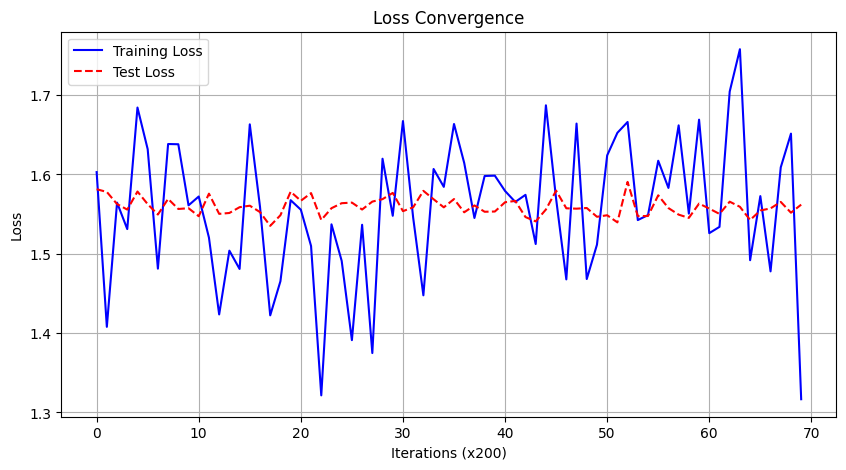

In [35]:
momentum_model_1by10alpha.plot_losses()

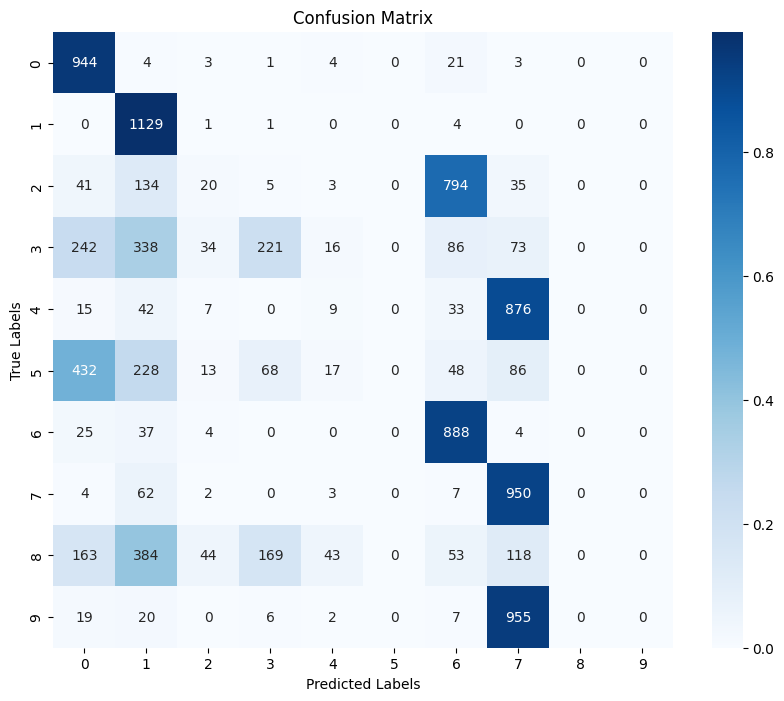

In [36]:
momentum_model_1by10alpha.plot_confusion_matrix(X_test, Y_test)

### Conclusion

While models are able to predict 0, 1, 6, and 7 well, they  fail to classify the other digits correctly. A lot of the samples are misclassified as 1 or 7, showing that the model is biased, the regularization has created too much bias, and left little room for variance, leading to an oversimplified model.

## Weight Decay 0.01

### SGD

In [42]:
input_dim = 28 * 28
output_dim = 10

layers = [
    FNNLayer(input_dim, 500, weight_decay = 0.01),
    ReLU(),
    FNNLayer(500, 250, weight_decay = 0.01),
    ReLU(),
    FNNLayer(250, 100, weight_decay = 0.01),
    ReLU(),
    FNNLayer(100, output_dim, weight_decay = 0.01)
]

sgd_model_1by100alpha = NN(layers)
optimizer = SGD()
loss = LogLoss()
sgd_model_1by100alpha.compile(loss=loss, optimizer=optimizer)
sgd_model_1by100alpha.fit(X_train, Y_train, X_test, Y_test)

Iteration: 200 Train Loss: 0.6478011788003758 Test Loss: 0.6027278642865362
Iteration: 400 Train Loss: 0.49035577070949193 Test Loss: 0.4141076848757327
Iteration: 600 Train Loss: 0.3131555977148571 Test Loss: 0.34514483951678854
Iteration: 800 Train Loss: 0.3401502261537856 Test Loss: 0.3130716323412736
Epoch: 1 Mean Train Loss: 0.5612367379592021 Train Accuracy: 85.32%
Iteration: 1000 Train Loss: 0.22011438787762588 Test Loss: 0.2921545442922081
Iteration: 1200 Train Loss: 0.1984796342604569 Test Loss: 0.27632887711451815
Iteration: 1400 Train Loss: 0.23487276367422702 Test Loss: 0.26579755649723946
Iteration: 1600 Train Loss: 0.34552557173767284 Test Loss: 0.2564873091975458
Iteration: 1800 Train Loss: 0.25915958187430516 Test Loss: 0.25029336146069675
Epoch: 2 Mean Train Loss: 0.26783633671550844 Train Accuracy: 92.97%
Iteration: 2000 Train Loss: 0.1588679850519502 Test Loss: 0.24608308594022127
Iteration: 2200 Train Loss: 0.23016463506576146 Test Loss: 0.24003048362658755
Iteratio

In [43]:
sgd_model_1by100alpha.evaluate(X_train, Y_train, X_test, Y_test)

Train loss: 0.18284910755199604 Train accuracy: 95.83%
Test loss: 0.19130740941414318 Test accuracy: 95.46%

Confusion Matrix:
 [[ 964    0    2    1    0    3    8    1    1    0]
 [   0 1120    2    3    0    1    3    1    5    0]
 [  11    1  970   10    6    0    7   11   15    1]
 [   0    1    6  973    1    6    0   12    8    3]
 [   1    3    3    0  943    0   12    2    2   16]
 [   5    1    0   14    5  848    7    2    7    3]
 [   7    3    0    0    9   13  921    0    5    0]
 [   0   17   16    4    5    1    0  970    0   15]
 [   4    5    4   13    9   16    8    7  900    8]
 [  11    8    1   10   21    4    0   10    7  937]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.97      0.99      0.98      1135
           2       0.97      0.94      0.95      1032
           3       0.95      0.96      0.95      1010
           4       0.94      0.96      0.95  

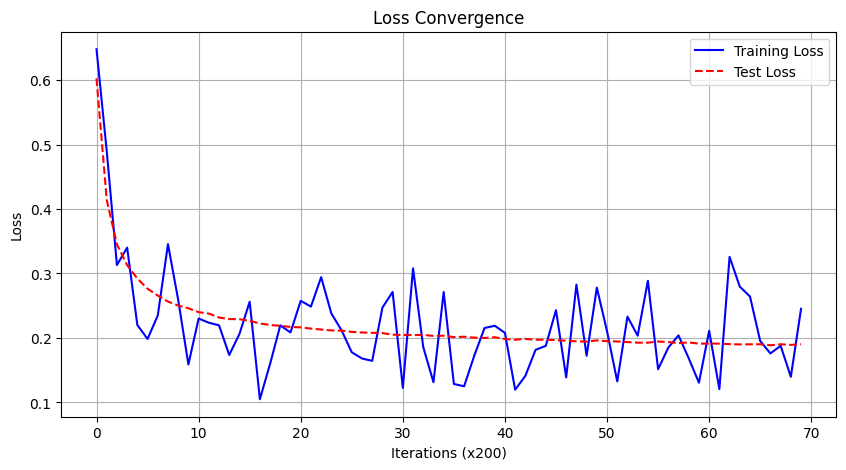

In [44]:
sgd_model_1by100alpha.plot_losses()

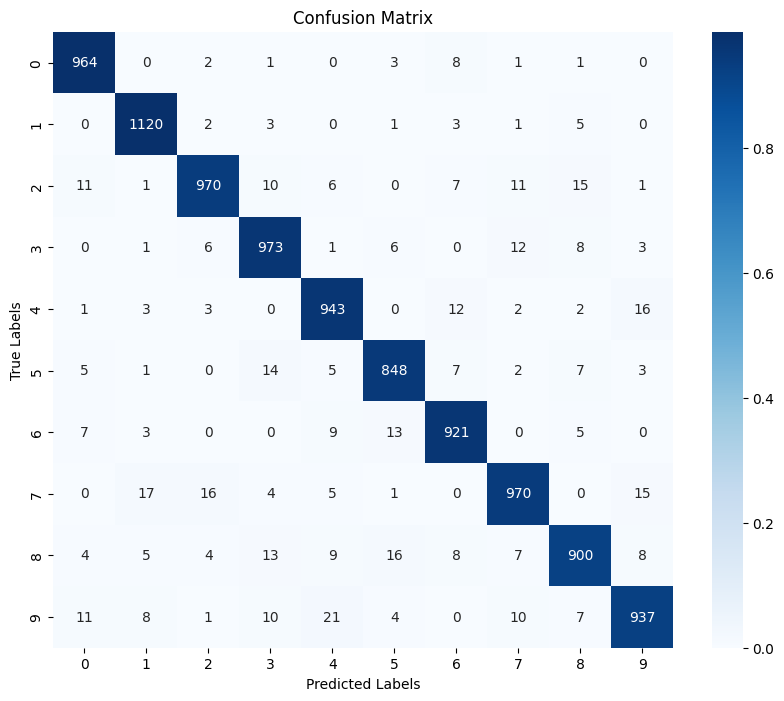

In [45]:
sgd_model_1by100alpha.plot_confusion_matrix(X_test, Y_test)

### Momentum

In [46]:
input_dim = 28 * 28
output_dim = 10

layers = [
    FNNLayer(input_dim, 500, weight_decay = 0.01),
    ReLU(),
    FNNLayer(500, 250, weight_decay = 0.01),
    ReLU(),
    FNNLayer(250, 100, weight_decay = 0.01),
    ReLU(),
    FNNLayer(100, output_dim, weight_decay = 0.01)
]

momentum_model_1by100alpha = NN(layers)
optimizer = Momentum()
loss = LogLoss()
momentum_model_1by100alpha.compile(loss=loss, optimizer=optimizer)
momentum_model_1by100alpha.fit(X_train, Y_train, X_test, Y_test)

Iteration: 200 Train Loss: 0.35832900072222074 Test Loss: 0.3076311752388113
Iteration: 400 Train Loss: 0.1818202912544873 Test Loss: 0.26489773891357865
Iteration: 600 Train Loss: 0.2582076104590476 Test Loss: 0.24015472183859732
Iteration: 800 Train Loss: 0.22304528152663256 Test Loss: 0.23836360249474361
Epoch: 1 Mean Train Loss: 0.3262232575408285 Train Accuracy: 91.25%
Iteration: 1000 Train Loss: 0.16036344210723985 Test Loss: 0.21637387479982273
Iteration: 1200 Train Loss: 0.27083984994038507 Test Loss: 0.2132798623922533
Iteration: 1400 Train Loss: 0.12122505837701608 Test Loss: 0.21431841648083247
Iteration: 1600 Train Loss: 0.26026568433131714 Test Loss: 0.21211364862405474
Iteration: 1800 Train Loss: 0.2548242944991669 Test Loss: 0.22047773093641143
Epoch: 2 Mean Train Loss: 0.2221437552869206 Train Accuracy: 94.38%
Iteration: 2000 Train Loss: 0.25465836245371887 Test Loss: 0.20731163431395122
Iteration: 2200 Train Loss: 0.6851621589257922 Test Loss: 0.21367113986559988
Itera

In [47]:
momentum_model_1by100alpha.evaluate(X_train, Y_train, X_test, Y_test)

Train loss: 0.19606497892555544 Train accuracy: 95.26%
Test loss: 0.20456957419414493 Test accuracy: 94.76%

Confusion Matrix:
 [[ 962    0    2    1    0    3    6    3    3    0]
 [   0 1119    5    1    0    0    3    2    5    0]
 [  10    2  985    4    3    0    6   10   10    2]
 [   0    1   21  949    0    8    0   12   17    2]
 [   1    6    5    0  923    0    9    5    5   28]
 [   5    1    1   25    5  820    9    3   18    5]
 [   7    3    1    0   13   16  912    1    5    0]
 [   1    7   24    2    3    0    0  966    0   25]
 [   5    3    7   13    9   12    7    7  896   15]
 [   7    6    3   10   16    3    0    8   12  944]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.97      0.99      0.98      1135
           2       0.93      0.95      0.94      1032
           3       0.94      0.94      0.94      1010
           4       0.95      0.94      0.94  

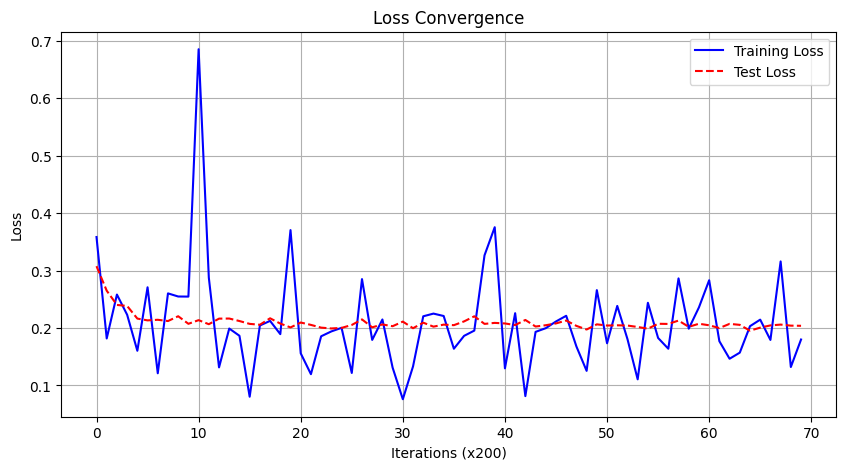

In [48]:
momentum_model_1by100alpha.plot_losses()

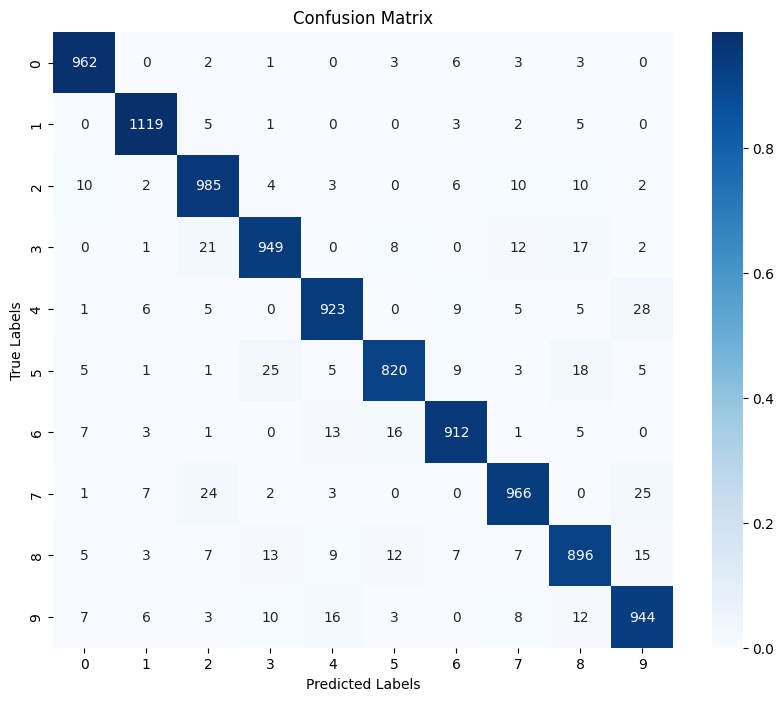

In [49]:
momentum_model_1by100alpha.plot_confusion_matrix(X_test, Y_test)

### Conclusion

For both the models, the train and test accuracies are very close, meaning that the regularization has done a good job of rpeventing overfitting.

## Weight Decay 0.001

### SGD

In [52]:
input_dim = 28 * 28
output_dim = 10

layers = [
    FNNLayer(input_dim, 500, weight_decay = 0.001),
    ReLU(),
    FNNLayer(500, 250, weight_decay = 0.001),
    ReLU(),
    FNNLayer(250, 100, weight_decay = 0.001),
    ReLU(),
    FNNLayer(100, output_dim, weight_decay = 0.001)
]

sgd_model_1by1000alpha = NN(layers)
optimizer = SGD()
loss = LogLoss()
sgd_model_1by1000alpha.compile(loss=loss, optimizer=optimizer)
sgd_model_1by1000alpha.fit(X_train, Y_train, X_test, Y_test)

Iteration: 200 Train Loss: 0.6835975935249171 Test Loss: 0.5842382672525204
Iteration: 400 Train Loss: 0.25429575060854626 Test Loss: 0.37671653321163046
Iteration: 600 Train Loss: 0.3281061832268368 Test Loss: 0.3166508808486087
Iteration: 800 Train Loss: 0.28410361974805665 Test Loss: 0.2746570832434464
Epoch: 1 Mean Train Loss: 0.5455771327433805 Train Accuracy: 85.49%
Iteration: 1000 Train Loss: 0.1013043303861238 Test Loss: 0.24732943719183298
Iteration: 1200 Train Loss: 0.24151709264219634 Test Loss: 0.23450896490160306
Iteration: 1400 Train Loss: 0.21067371879090568 Test Loss: 0.21765580355891975
Iteration: 1600 Train Loss: 0.12327784020087416 Test Loss: 0.21079470197321035
Iteration: 1800 Train Loss: 0.21285091864952943 Test Loss: 0.1992364534515762
Epoch: 2 Mean Train Loss: 0.2151899523448258 Train Accuracy: 93.89%
Iteration: 2000 Train Loss: 0.10443868589815222 Test Loss: 0.1888553290897144
Iteration: 2200 Train Loss: 0.2523722019441601 Test Loss: 0.18050698269584192
Iteratio

In [53]:
sgd_model_1by1000alpha.evaluate(X_train, Y_train, X_test, Y_test)

Train loss: 0.04121106449203172 Train accuracy: 99.13%
Test loss: 0.1004162244304904 Test accuracy: 97.19%

Confusion Matrix:
 [[ 967    0    1    1    0    2    3    2    2    2]
 [   0 1123    4    0    0    1    4    1    2    0]
 [   4    1 1000    3    3    1    4    7    9    0]
 [   0    0    6  988    0    4    0    4    6    2]
 [   1    0    6    0  953    0    6    3    3   10]
 [   2    0    0   12    1  860    5    2    8    2]
 [   6    3    2    1    6    5  930    1    4    0]
 [   0    7   11    1    2    1    0  994    1   11]
 [   3    2    5    8    2    4    1    6  940    3]
 [   3    6    1    9   10    3    1    7    5  964]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.97      0.98      0.97      1010
           4       0.98      0.97      0.97   

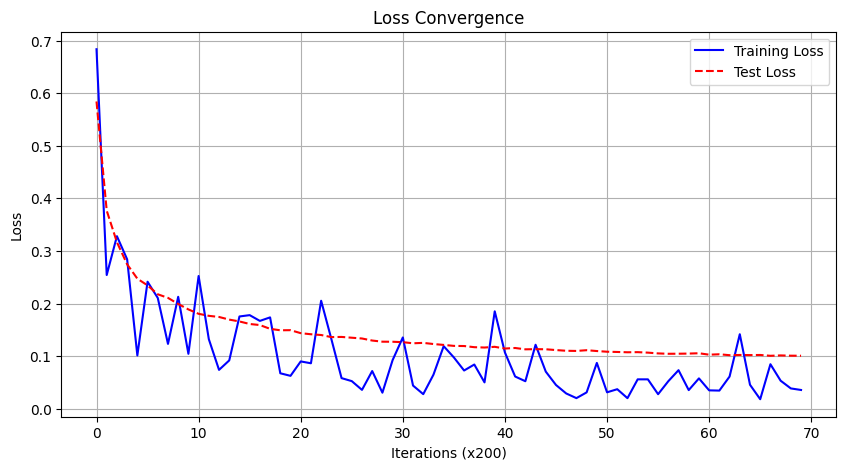

In [54]:
sgd_model_1by1000alpha.plot_losses()

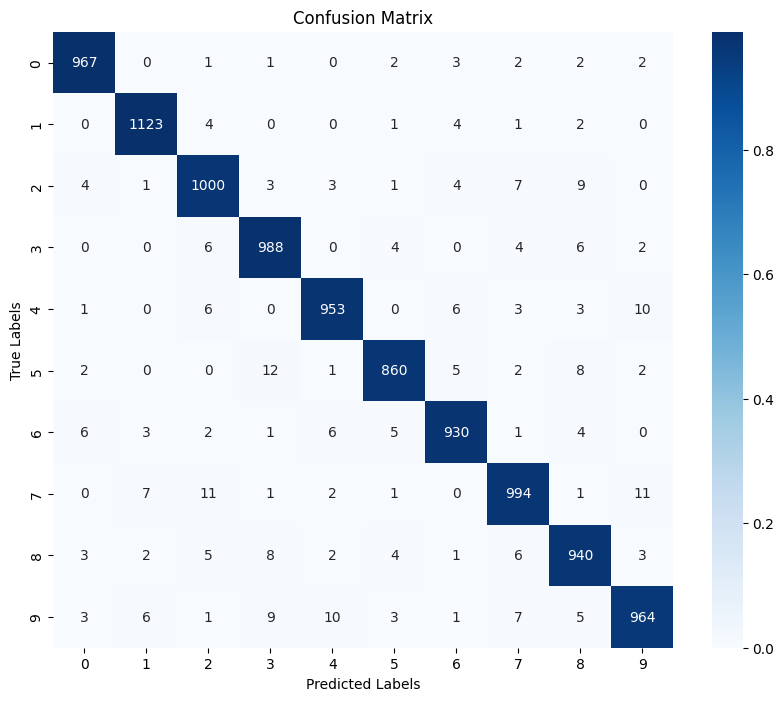

In [55]:
sgd_model_1by1000alpha.plot_confusion_matrix(X_test, Y_test)

### Momentum

In [56]:
input_dim = 28 * 28
output_dim = 10

layers = [
    FNNLayer(input_dim, 500, weight_decay = 0.001),
    ReLU(),
    FNNLayer(500, 250, weight_decay = 0.001),
    ReLU(),
    FNNLayer(250, 100, weight_decay = 0.001),
    ReLU(),
    FNNLayer(100, output_dim, weight_decay = 0.001)
]

momentum_model_1by1000alpha = NN(layers)
optimizer = Momentum()
loss = LogLoss()
momentum_model_1by1000alpha.compile(loss=loss, optimizer=optimizer)
momentum_model_1by1000alpha.fit(X_train, Y_train, X_test, Y_test)

Iteration: 200 Train Loss: 0.14017232233120452 Test Loss: 0.2618560127260318
Iteration: 400 Train Loss: 0.2028724547730099 Test Loss: 0.2293107173992485
Iteration: 600 Train Loss: 0.21186401203850772 Test Loss: 0.20011081457850602
Iteration: 800 Train Loss: 0.3124380139871451 Test Loss: 0.18123690615191165
Epoch: 1 Mean Train Loss: 0.2803593746808626 Train Accuracy: 92.02%
Iteration: 1000 Train Loss: 0.033148227378844486 Test Loss: 0.14165150994853565
Iteration: 1200 Train Loss: 0.06784791094896057 Test Loss: 0.15012010711830504
Iteration: 1400 Train Loss: 0.21037503623002932 Test Loss: 0.1295933321537118
Iteration: 1600 Train Loss: 0.052952529474863216 Test Loss: 0.13754443466368582
Iteration: 1800 Train Loss: 0.0872768369087927 Test Loss: 0.11996823820110246
Epoch: 2 Mean Train Loss: 0.11297820664916801 Train Accuracy: 96.83%
Iteration: 2000 Train Loss: 0.02877702931912434 Test Loss: 0.12297897724953132
Iteration: 2200 Train Loss: 0.08024569490625859 Test Loss: 0.11462726713304269
It

In [57]:
momentum_model_1by1000alpha.evaluate(X_train, Y_train, X_test, Y_test)

Train loss: 0.03628649499066147 Train accuracy: 99.13%
Test loss: 0.08997512948958328 Test accuracy: 97.57%

Confusion Matrix:
 [[ 958    1    3    0    0    1   14    1    2    0]
 [   0 1124    6    0    0    0    2    0    3    0]
 [   1    3 1010    0    1    0    2    9    5    1]
 [   0    0    6  984    0    8    0    7    4    1]
 [   0    0    8    0  944    1    5    4    2   18]
 [   3    0    0    6    2  866    7    2    5    1]
 [   1    2    2    0    2    5  945    0    1    0]
 [   0    7   12    0    1    0    0 1003    2    3]
 [   3    0    2    1    2    5    2    6  950    3]
 [   2    2    0    8    3    1    1   15    4  973]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.98      0.97      1032
           3       0.98      0.97      0.98      1010
           4       0.99      0.96      0.97  

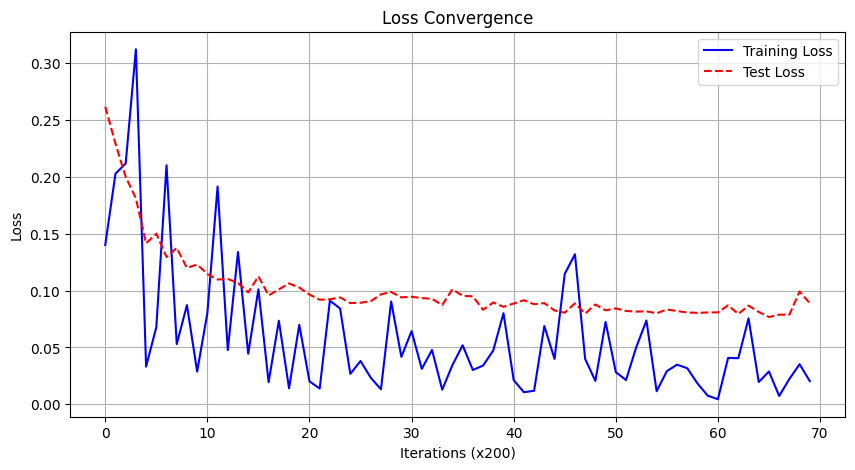

In [58]:
momentum_model_1by1000alpha.plot_losses()

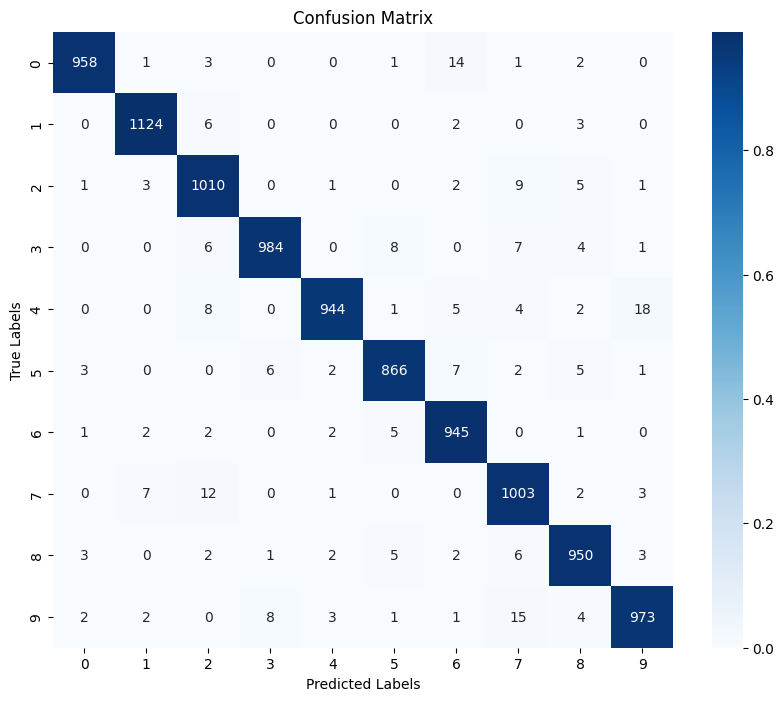

In [59]:
momentum_model_1by1000alpha.plot_confusion_matrix(X_test, Y_test)

### Conclusion
Regularization value is preety low and performance is similar to when there is 0 weight decay. however, the overfitting is slighlty less in this case.

## Momentum with no weight decay

I have to run it again, because the previous results can't be accessed in this runtime

In [60]:
input_dim = 28 * 28
output_dim = 10

layers = [
    FNNLayer(input_dim, 500),
    ReLU(),
    FNNLayer(500, 250),
    ReLU(),
    FNNLayer(250, 100),
    ReLU(),
    FNNLayer(100, output_dim)
]

best_model_momentum = NN(layers)
optimizer = Momentum()
loss = LogLoss()
best_model_momentum.compile(loss=loss, optimizer=optimizer)
best_model_momentum.fit(X_train, Y_train, X_test, Y_test)

Iteration: 200 Train Loss: 0.29511228595958583 Test Loss: 0.29043277426825964
Iteration: 400 Train Loss: 0.20196479220999358 Test Loss: 0.20543085299189284
Iteration: 600 Train Loss: 0.25417783006938643 Test Loss: 0.20233656358153515
Iteration: 800 Train Loss: 0.17070943502240643 Test Loss: 0.17171421267513934
Epoch: 1 Mean Train Loss: 0.27675109148683513 Train Accuracy: 92.36%
Iteration: 1000 Train Loss: 0.3071961127663855 Test Loss: 0.15803620807412064
Iteration: 1200 Train Loss: 0.06952389685672869 Test Loss: 0.1388915068203119
Iteration: 1400 Train Loss: 0.1205475890193361 Test Loss: 0.13475591142211144
Iteration: 1600 Train Loss: 0.14974644664971043 Test Loss: 0.12260378322325236
Iteration: 1800 Train Loss: 0.021792207181794573 Test Loss: 0.12710132475199182
Epoch: 2 Mean Train Loss: 0.09882154075915348 Train Accuracy: 97.12%
Iteration: 2000 Train Loss: 0.006480515709215295 Test Loss: 0.1204344687203026
Iteration: 2200 Train Loss: 0.0527387002367363 Test Loss: 0.13469315353325
Ite

In [61]:
best_model_momentum.evaluate(X_train, Y_train, X_test, Y_test)

Train loss: 0.00036201082777796836 Train accuracy: 100.00%
Test loss: 0.126786125912051 Test accuracy: 97.83%

Confusion Matrix:
 [[ 971    0    1    3    1    1    1    1    1    0]
 [   0 1128    2    1    0    1    2    0    1    0]
 [   4    1 1009    2    1    0    4    4    7    0]
 [   0    0    3  992    0    4    0    3    2    6]
 [   1    0    7    0  959    0    3    1    1   10]
 [   2    0    0   10    2  867    5    2    3    1]
 [   4    2    2    1    6    5  937    0    1    0]
 [   1    3    9    1    3    0    0  998    2   11]
 [   1    0    4    8    6    4    4    2  941    4]
 [   3    2    0    6    6    3    1    4    3  981]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.97      0.98      0.98      1010
           4       0.97      0.98      0.98

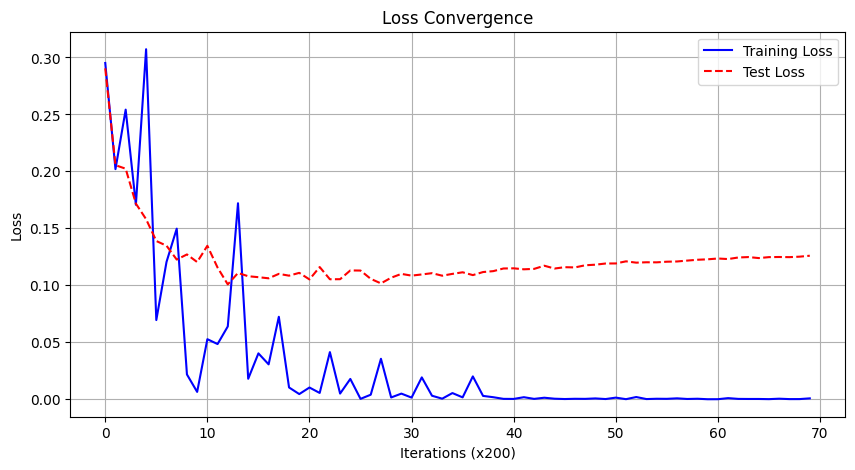

In [62]:
best_model_momentum.plot_losses()

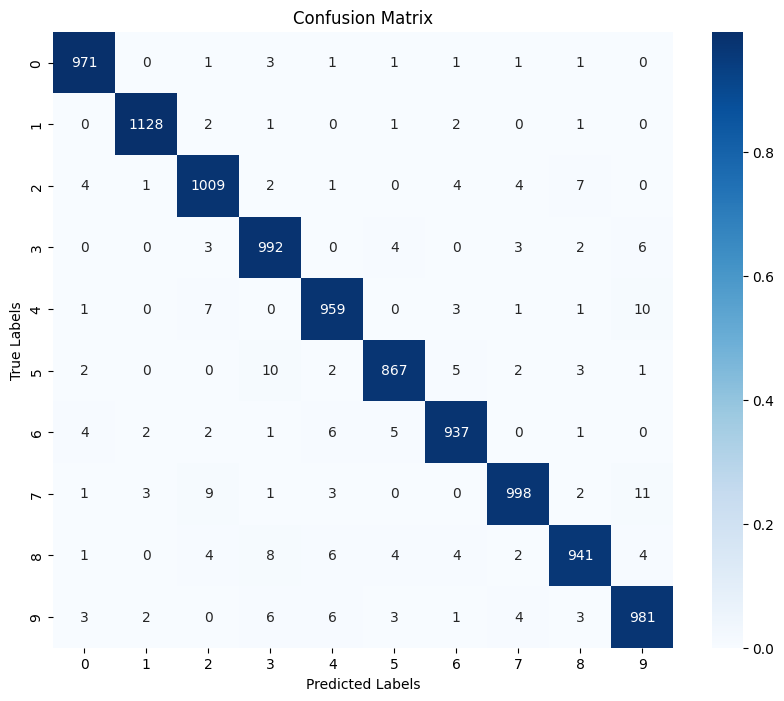

In [63]:
best_model_momentum.plot_confusion_matrix(X_test, Y_test)

## Comparison

We compare the perfromance with the Momentum optimizer, as it has been the best for performer in all the runs so far.

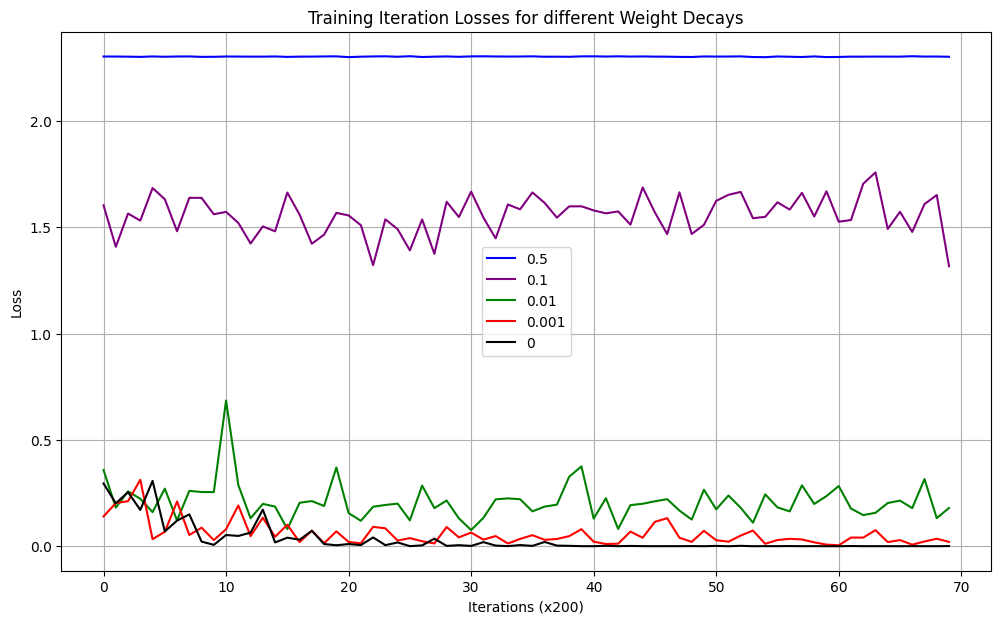

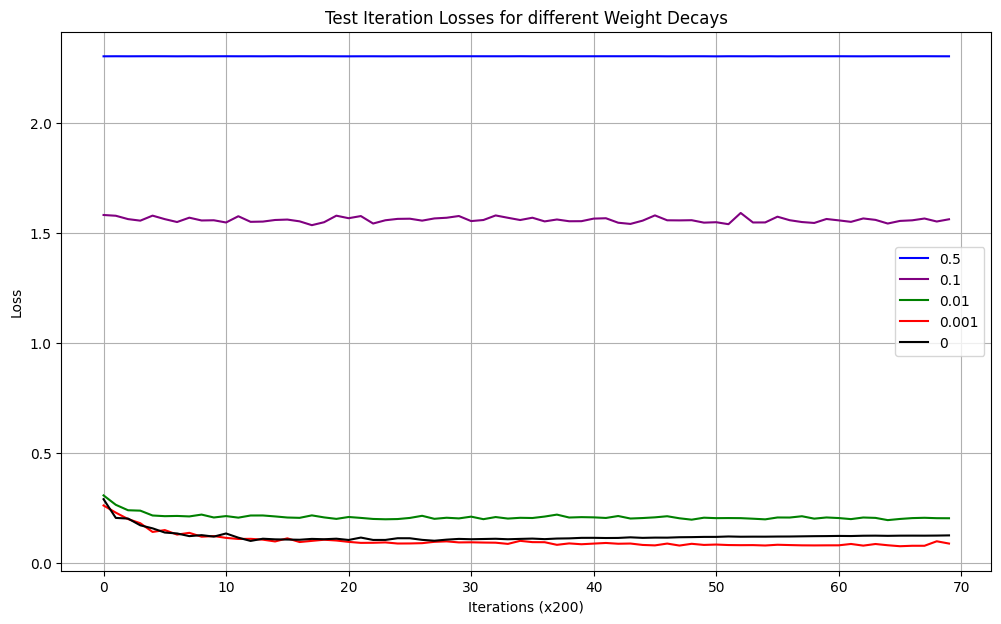

In [64]:
import matplotlib.pyplot as plt

def plot_models_losses(models, labels, title, attribute):
    plt.figure(figsize=(12, 7))

    colors = ['blue', 'purple', 'green', 'red', 'black']

    for i, model in enumerate(models):
        losses = getattr(model, attribute)
        plt.plot(losses, label=labels[i], color=colors[i])

    plt.xlabel('Iterations (x200)')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

model1 = momentum_model_halfalpha
model2 = momentum_model_1by10alpha
model3 = momentum_model_1by100alpha
model4 = momentum_model_1by1000alpha
model5 = best_model_momentum

models = [model1, model2, model3, model4, model5]
labels = ['0.5', '0.1', '0.01', '0.001', '0']

# Plots training iteration losses
plot_models_losses(models, labels, 'Training Iteration Losses for different Weight Decays', 'iteration_losses')

# Plots test iteration losses
plot_models_losses(models, labels, 'Test Iteration Losses for different Weight Decays', 'iteration_test_losses')

## Observations

It is clear that models with very high regularization (0.5) are hardly learning, and the accuracy close to 10% shows that the model is almost mimicing the behaviour of making a guess for the class.

We see the test acuuracy improves as we keep decreasing the regularization, however the gap between train accuracy/loss and test accuracy/loss also increases which would indicate overfitting. However, the overfitting is quite minimal for this dataset in all cases, and can be excused in order to get a good accuracy.

Summary of results:

Weight Decay  | Test Accuracy | Train Accuracy | Train Loss| Test Loss
-------------------|------------------|---------------|------------|------------
      0.5 |  11.35% |  11.24%| 2.3025 | 2.3024|
       0.1 | 41.61% | 42.02% | 1.5583 | 1.5578 |
       0.01 |  94.76% | 95.26% | 0.1961 | 0.2046 |
       0.001  | 97.57% | 99.13% | 0.0362 | 0.0899 |
       0  | 97.83% | 100.00% | 0.00036 | 0.1268 |
